# Veredas


## Datos: qué necesitamos y cómo estructurarlos (ETL)

**Fuentes internas (Veredas):**

- Inventario de lotes: lote_id, etapa, manzana, lote, superficie_m2, frente, fondo, forma, topografía, uso, estatus (disponible/apartado/vendido), fecha_publicación, fecha_apartado, fecha_venta, precio_lista_total, descuentos, precio_cierre_total, mantenimiento(HOA), servicios (agua, luz, drenaje), amenidades_proyecto, distancia_playa_m, distancia_marina_m, distancia_malecón_m, accesos(min), seguridad, vistas
- Transacciones: lote_id, fecha, precio_cierre_total, forma_pago, %enganche, plazos, broker, canal
- Leads/CRM: lead_id, fecha, origen, intención (inversión/vivienda), presupuesto, nacionalidad, residencia, ocupación, edad (rango), familia(si/no), estatus_lead


In [5]:
# ------ Carga y normalización ------- #
import pandas as pd
import numpy as np
from unidecode import unidecode

# Leer el archivo Excel correctamente
inv = pd.read_excel(
    "C:/Users/julio/OneDrive/Documentos/Trabajo/Ideas Frescas/Proyectos/Veredas/Datos/inventario veredas.xlsx"
)

ventas = pd.read_excel(
    "C:/Users/julio/OneDrive/Documentos/Trabajo/Ideas Frescas/Proyectos/Veredas/Datos/informacion ventas.xlsx"
)

perfil = pd.read_excel(
    "C:/Users/julio/OneDrive/Documentos/Trabajo/Ideas Frescas/Proyectos/Veredas/Datos/perfil comprador.xlsx"
)

# 1.2 Limpieza de columnas y nombres
def clean_cols(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[()]", "", regex=True)
    )
    return df

# 1.3 Quitar símbolos de $ y comas en precios
def to_num(s):
    if pd.isna(s):
        return np.nan
    return pd.to_numeric(
        str(s).replace("$","").replace(",","").strip(), errors="coerce"
    )


inv = clean_cols(inv)


ventas = clean_cols(ventas)
ventas.drop(columns=["id_lote"], inplace=True)
perfil = clean_cols(perfil)
perfil.drop(columns=["id_lote"], inplace=True)

num_cols_inv = ["m2","precio_m2","precio_total"]

for c in num_cols_inv:
    inv[c] = inv[c].apply(to_num)

num_cols_ventas = [
    "area_m2","precio_m2_lista","precio_contrato","monto_apartado",
    "monto_enganche","monto_mensualidad","seguro_vida",
    "precio_contrato_-_seguro_de_vida","precio_m2_real",
    "descuento","total_pagado","pendiente_pagar"
]

for c in num_cols_ventas:
    ventas[c] = ventas[c].apply(to_num)

# ------ Estructura y llaves --------- #
'''
Vamos a crear una clave única de lote (proyecto_id + condominio + lote) para unir inventario, ventas y perfil.

Fechas en formato datetime.date para análisis temporal
'''

# 2.1 Clave única de lote
for df in [inv, ventas, perfil]:
    df["lote_id"] = df["condominio"].astype(str).str.strip() + "-" + df["lote"].astype(str).str.strip()

# 2.2 Fechas
date_cols_ventas = [
    "fecha_de_firma","fecha_apartado","fecha_pago_enganche",
    "fecha_1era_mensualidad","fecha_fin_cobranza"
]
for c in date_cols_ventas:
    ventas[c] = pd.to_datetime(ventas[c], errors="coerce").dt.date

perfil["fecha_nacimiento"] = pd.to_datetime(perfil["fecha_nacimiento"], errors="coerce").dt.date


# 2. FUNCIÓN DE LIMPIEZA INICIAL
# Esta función convierte todo a mayúsculas, quita espacios y acentos.
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    # Convierte a mayúsculas, quita espacios extra y acentos
    texto_limpio = unidecode(texto).strip().upper()
    return texto_limpio

# Aplicamos la limpieza inicial a la columna
perfil['ocupacion'] = perfil['ocupacion'].apply(limpiar_texto)


# 3. DICCIONARIO DE MAPEO PARA ESTANDARIZAR
# Las claves son el nombre estándar que quieres usar.
# Los valores son una lista de todas las variaciones que deben ser reemplazadas.
mapeo_ocupaciones = {
    'ABOGADO': ['ABOGADA'],
    'ADMINISTRADOR': ['ADMINISTRADORA', 'ADMINISTRADORES'],
    'ARQUITECTO': ['ARQUITECTA'],
    'ASISTENTE DE ENFERMERIA': ['ASISTENTE ENFERMERA'],
    'CONTADOR': ['CONTADORA'],
    'DIRECTOR': ['DIRECTORA'],
    'MAESTRO': ['MAESTRA', 'PROFESOR', 'PROFESORA', 'DOCENTE', 'EDUCACION'],
    'EMPLEADO': ['EMPLEADA'],
    'ENFERMERO': ['ENFERMERA'],
    'JUBILADO': ['JUBILADA', 'PENSIONADO', 'PENSIONADA'],
    'MEDICO': ['DOCTOR', 'DOCTORA'],
    'VENDEDOR': ['VENDEDORA', 'VENTAS', 'COMERCIANTE'],
    # Caso especial: 'SOLTERA' no es una ocupación
    'NO ESPECIFICADO': ['SOLTERA']
}

# Invertimos el diccionario para poder usar el método .replace() de pandas
# Esto crea un mapa de: {'variación': 'estándar'}
mapeo_inverso = {valor: clave for clave, valores in mapeo_ocupaciones.items() for valor in valores}

# 4. APLICAR EL MAPEO FINAL
# Usamos .replace() en la columna limpia. Los valores que no están en el
# mapeo_inverso se mantendrán como están.
perfil['ocupacion'] = perfil['ocupacion'].replace(mapeo_inverso)





# ======= Procesar datos de inventario ======= #

# Agregar estatus
inv["estatus"] = "Disponible"

# Reordenar columnas
cols_final = ["lote_id", "condominio", "lote", "m2", "precio_m2", "precio_total", "estatus"]
inv = inv[cols_final]
inv  = inv.rename(columns={ 'precio_m2': 'precio_m2_lista','precio_total': 'precio_lista'})

# ======= Procesar datos de ventas ======= #

# Agregar estatus de venta
ventas["estatus"] = "Vendido"
ventas["precio_lista"] = ventas["precio_m2_lista"] * ventas["area_m2"]
ventas["precio_m2_venta"] = ventas["precio_contrato"] / ventas["area_m2"]
ventas_limpio = ventas[["lote_id", "condominio", "lote", "area_m2",'precio_m2_lista', 'precio_lista', 'precio_m2_venta', 'precio_contrato', "estatus"]].copy()
ventas_limpio = ventas_limpio.rename(columns={'area_m2': 'm2', 'precio_contrato': 'precio_contrato/venta'})


# ------ Unificación ------ #
'''
Unimos inventario + ventas

Hacemos un primer reporte exploratorio (EDA) para entender distribución de m², precios, descuentos, y perfil de comprador
'''

# Unir disponibles y vendidos
info_veredas_completo = pd.concat([ventas_limpio,inv], ignore_index=True)

info_veredas_completo.head(5)


lote_id condominio lote     m2  precio_m2_lista  precio_lista  \
0    C1-1         C1    1  144.0          8000.00    1152000.00   
1   C1-10         C1   10  128.0          7063.88     904176.64   
2  C1-100         C1  100  132.0          4986.00     658152.00   
3  C1-101         C1  101  129.0          4986.00     643194.00   
4  C1-102         C1  102  136.0          4986.00     678096.00   

   precio_m2_venta  precio_contrato/venta  estatus  
0      8051.611111             1159432.00  Vendido  
1      6819.231797              872861.67  Vendido  
2      4992.204545              658971.00  Vendido  
3      5028.680930              648699.84  Vendido  
4      4984.533529              677896.56  Vendido

In [6]:
ventas.columns

Index(['condominio', 'lote', 'area_m2', 'precio_m2_lista', 'proyecto',
       'propietario', 'plazo', 'fecha_de_firma', 'precio_contrato',
       'fecha_apartado', 'monto_apartado', 'fecha_pago_enganche',
       'monto_enganche', '#_mensualidades', 'fecha_1era_mensualidad',
       'monto_mensualidad', 'fecha_fin_cobranza', 'seguro_vida',
       'precio_contrato_-_seguro_de_vida', 'precio_m2_real', 'descuento',
       'total_pagado', 'pendiente_pagar', 'precio_m2', 'lote_id', 'estatus',
       'precio_lista', 'precio_m2_venta'],
      dtype='object')

In [7]:
import pandas as pd

# Asegúrate de que 'fecha_apartado' sea tipo datetime
ventas["fecha_apartado"] = pd.to_datetime(ventas["fecha_apartado"], errors="coerce")
ventas['fecha_de_firma'] = pd.to_datetime(ventas["fecha_de_firma"], errors="coerce")

# Calcular la fecha mínima por condominio
fecha_inicio = ventas.groupby("condominio")["fecha_apartado"].transform("min")

# Asignar nueva columna
ventas["fecha_inicio_venta"] = fecha_inicio


In [10]:
fecha_inicio_lote = ventas["fecha_apartado"].fillna(ventas["fecha_inicio_venta"])
dias_venta = (ventas["fecha_de_firma"] - fecha_inicio_lote).dt.days

# Evita negativos y deja NaN si no hay firma
ventas["dias_a_la_venta"] = dias_venta.mask(dias_venta < 0, np.nan)
ventas

condominio  lote  area_m2  precio_m2_lista proyecto  \
0           C1     1      144          8000.00  Trassen   
1           C1    10      128          7063.88  Trassen   
2           C1   100      132          4986.00  Trassen   
3           C1   101      129          4986.00  Trassen   
4           C1   102      136          4986.00  Trassen   
..         ...   ...      ...              ...      ...   
788         C5    74      104          7486.50  Trassen   
789         C5    99      103          7486.50  Trassen   
790         M3    92      150          7324.35  Trassen   
791         SF     5      426          4600.00  Trassen   
792         SF     9      421          4000.00  Trassen   

                            propietario    plazo fecha_de_firma  \
0                  Raúl Quintero Garcia   18 MSI     2022-11-30   
1                Lucia Gonzalez Vidales   24 MSI     2023-09-25   
2           Jose Luis Carrillo Martínez   36 MSI     2021-12-07   
3                Rolando Alzate Quevedo   36 MSI     2022-09-09   
4               La Ilustración SA de CV   12 MSI     2022-06-23   
..                                  ...      ...            ...   
788  Ingrid Janeysi Gutiérrez Ontiveros  CONTADO     2025-06-20   
789               Emmanuel Velarde Páez   36 MSI     2024-11-29   
790             Rafael González Bonilla   36 MSI     2025-01-22   
791           Maria Luisa Prado Salazar   36 MSI     2024-08-27   
792                 Oscar Morán Morales   36 MSI     2023-05-30   

     precio_contrato fecha_apartado  ...  descuento total_pagado  \
0         1159432.00     2022-06-01  ...  -0.004989   1159491.45   
1          872861.67     2023-08-01  ...   0.038503    835628.90   
2          658971.00            NaT  ...   0.003802    658971.00   
3          648699.84            NaT  ...  -0.003399    626911.04   
4          677896.56            NaT  ...   0.001926    677886.54   
..               ...            ...  ...        ...          ...   
788        692950.00     2025-05-15  ...   0.123596    692950.00   
789        777116.64     2024-11-19  ...  -0.003483    381805.00   
790       1102037.74     2024-12-31  ...  -0.000067    394000.00   
791       1963169.60     2024-04-04  ...  -0.000131    697482.25   
792       1644236.24     2023-02-01  ...   0.026251   1169073.88   

     pendiente_pagar    precio_m2 lote_id  estatus precio_lista  \
0               0.00  8051.611111    C1-1  Vendido   1152000.00   
1           37232.70  6819.231797   C1-10  Vendido    904176.64   
2               0.18  4992.204545  C1-100  Vendido    658152.00   
3           21788.94  5028.680930  C1-101  Vendido    643194.00   
4               9.97  4984.533529  C1-102  Vendido    678096.00   
..               ...          ...     ...      ...          ...   
788             0.00  6662.980769   C5-74  Vendido    778596.00   
789        395311.68  7544.821748   C5-99  Vendido    771109.50   
790        708037.76  7346.918267   M3-92  Vendido   1098652.50   
791       1265687.31  4608.379343    SF-5  Vendido   1959600.00   
792        475163.12  3905.549264    SF-9  Vendido   1684000.00   

     precio_m2_venta  fecha_inicio_venta  dias_a_la_venta  
0        8051.611111          2020-12-01            182.0  
1        6819.231797          2020-12-01             55.0  
2        4992.204545          2020-12-01            371.0  
3        5028.680930          2020-12-01            647.0  
4        4984.533529          2020-12-01            569.0  
..               ...                 ...              ...  
788      6662.980769          2023-06-01             36.0  
789      7544.821748          2023-06-01             10.0  
790      7346.918267          2024-12-31             22.0  
791      4608.379343          2023-02-01            145.0  
792      3905.549264          2023-02-01            118.0  

[793 rows x 30 columns]

In [ ]:
# --- Rangos de área ---
bins   = [-np.inf, 100, 110, 120, 130, 140, 160, 180, np.inf]
labels = ["<100","100-110","110-120","120-130","130-140","140-160","160-180","≥180"]

ventas["rango_area_m2"] = pd.cut(ventas["area_m2"], bins=bins, labels=labels, right=False)


# --- Agrupar por condominio y rango de área ---
res = (ventas
       .groupby(["condominio", "rango_area_m2"], dropna=False)
       .agg(
           lotes=("lote", "count"),
           dias_prom=("dias_a_la_venta", "mean"),
           dias_med=("dias_a_la_venta", "median"),
           dias_min=("dias_a_la_venta", "min"),
           dias_max=("dias_a_la_venta", "max")
       )
       .reset_index()
       .sort_values(["condominio", "rango_area_m2"])
)

# Opcional: redondear días
res[["dias_prom", "dias_med"]] = res[["dias_prom", "dias_med"]].round(1)

# --- Si solo quieres mostrar ciertos rangos (por ejemplo "<100" y "110-120") ---
filt = res["rango_area_m2"].isin(["<100", "110-120"])
res_filtrado = res.loc[filt].copy()

# 'res' = tabla completa; 'res_filtrado' = solo <100 y 110-120


C:\Users\julio\AppData\Local\Temp\ipykernel_20080\3735894670.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condominio", "rango_area_m2"], dropna=False)


In [22]:
res = res[res['lotes']>0].copy()
res

condominio rango_area_m2  lotes  dias_prom  dias_med  dias_min  dias_max
3          C1       120-130     90      313.0      98.5      28.0    1032.0
4          C1       130-140     58      360.3     108.0      26.0    1032.0
5          C1       140-160     31      256.4      78.0      26.0    1079.0
6          C1       160-180     12      446.8     508.5      55.0     930.0
7          C1          ≥180      1      720.0     720.0     720.0     720.0
11         C3       120-130    189      262.2      86.0       0.0    2044.0
12         C3       130-140      4       76.2      81.0      38.0     105.0
13         C3       140-160     12      179.1      68.0       5.0    1344.0
14         C3       160-180      1       78.0      78.0      78.0      78.0
15         C3          ≥180      1       35.0      35.0      35.0      35.0
19         C4       120-130    195      856.5     669.5      22.0    2405.0
20         C4       130-140      8      733.6    1062.5      44.0    1215.0
21         C4       140-160      6      786.7     477.0     334.0    1992.0
22         C4       160-180     13      769.2     733.0      37.0    1606.0
23         C4          ≥180      1      213.0     213.0     213.0     213.0
25         C5       100-110    129       51.1      43.0       0.0     273.0
26         C5       110-120     23       55.8      42.0       0.0     273.0
27         C5       120-130      4       69.0      60.5      36.0     119.0
28         C5       130-140      1       38.0      38.0      38.0      38.0
29         C5       140-160      1       89.0      89.0      89.0      89.0
30         C5       160-180      2       48.5      48.5      19.0      78.0
31         C5          ≥180      8       39.1      35.0      29.0      64.0
37         M3       140-160      1       22.0      22.0      22.0      22.0
47         SF          ≥180      2      131.5     131.5     118.0     145.0

In [28]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- Asegurar orden de rangos (ajústalo a tus etiquetas reales) ---
orden_rangos = ["<100","100-110","110-120","120-130","130-140","140-160","160-180","≥180"]
res = res.copy()
if "rango_area_m2" in res.columns:
    res["rango_area_m2"] = pd.Categorical(res["rango_area_m2"], categories=orden_rangos, ordered=True)

# --- Calcular columnas auxiliares para error bars (max y min respecto al promedio) ---
res["err_plus"]  = res["dias_max"] - res["dias_prom"]
res["err_minus"] = res["dias_prom"] - res["dias_min"]

# --- Filtra rangos vacíos si los hubiera ---
res_plot = res[(res["lotes"] > 0) & res["rango_area_m2"].notna()].copy()

# --- Scatter con barras de error y facet por condominio ---
fig = px.scatter(
    res_plot,
    x="rango_area_m2",
    y="dias_prom",
    size="lotes",
    color="rango_area_m2",              # color por rango (para leer más rápido)
    facet_col="condominio",             # 1 panel por condominio
    facet_col_wrap=3,                   # ajusta cuántos por fila
    error_y="err_plus",
    error_y_minus="err_minus",
    hover_data={
        "lotes": True,
        "dias_med": ":.1f",
        "dias_min": True,
        "dias_max": True,
        "rango_area_m2": False,         # ya está en el eje
    },
    category_orders={"rango_area_m2": orden_rangos},
    title="Tiempo a la venta por rango de área — Promedio con min–max (facet por condominio)"
)

# --- Estética "senior" ---
fig.update_traces(marker_line_width=0.5, marker_line_color="rgba(0,0,0,0.35)")
fig.update_layout(
    template="simple_white",
    legend_title_text="Rango de área (m²)",
    xaxis_title="Rango de área (m²)",
    yaxis_title="Días a la venta (promedio)",
    hovermode="closest",
    margin=dict(l=40, r=20, t=60, b=40),
)

# Líneas de cuadrícula suaves
for a in fig.layout:
    if a.startswith("yaxis"):
        fig.layout[a].gridcolor = "rgba(0,0,0,0.08)"

# Opcional: anotar que el punto es promedio y las barras son min–max
fig.add_annotation(
    xref="paper", yref="paper", x=0, y=1.08, showarrow=False,
    text="• Punto: promedio | • Barra: min–max | • Tamaño: # de lotes",
    font=dict(size=12, color="gray")
)

fig.show()


In [27]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# --- Boxplot (solo cajas, sin puntos) ---
fig_box = px.box(
    ventas,
    x="rango_area_m2", y="dias_a_la_venta", color="condominio",
    points=False,  # sin puntos
    category_orders={"rango_area_m2": orden_rangos},
)

# --- Strip / scatter con "jitter manual" ---
# Para simular jitter, agregamos un pequeño ruido a la posición X
ventas_jitter = ventas.copy()
ventas_jitter["x_jitter"] = ventas_jitter["rango_area_m2"].cat.codes + np.random.uniform(-0.2, 0.2, size=len(ventas_jitter))

fig_strip = px.scatter(
    ventas_jitter,
    x="x_jitter", y="dias_a_la_venta", color="condominio",
    hover_data=["condominio","lote","area_m2","precio_m2_venta","dias_a_la_venta"],
    opacity=0.5
)

# Reemplazar etiquetas X originales
fig_strip.update_xaxes(
    tickvals=list(range(len(orden_rangos))),
    ticktext=orden_rangos,
    title="Rango de área (m²)"
)

# --- Combinar capas ---
fig = go.Figure(data=fig_box.data + fig_strip.data)

# --- Estética ---
fig.update_layout(
    title="Días a la venta por rango de área y condominio",
    template="simple_white",
    legend_title_text="Condominio",
    hovermode="x unified",
    margin=dict(l=40, r=20, t=60, b=40),
    yaxis=dict(title="Días a la venta", tickformat=",d", rangemode="tozero", gridcolor="rgba(0,0,0,0.08)")
)

fig.show()



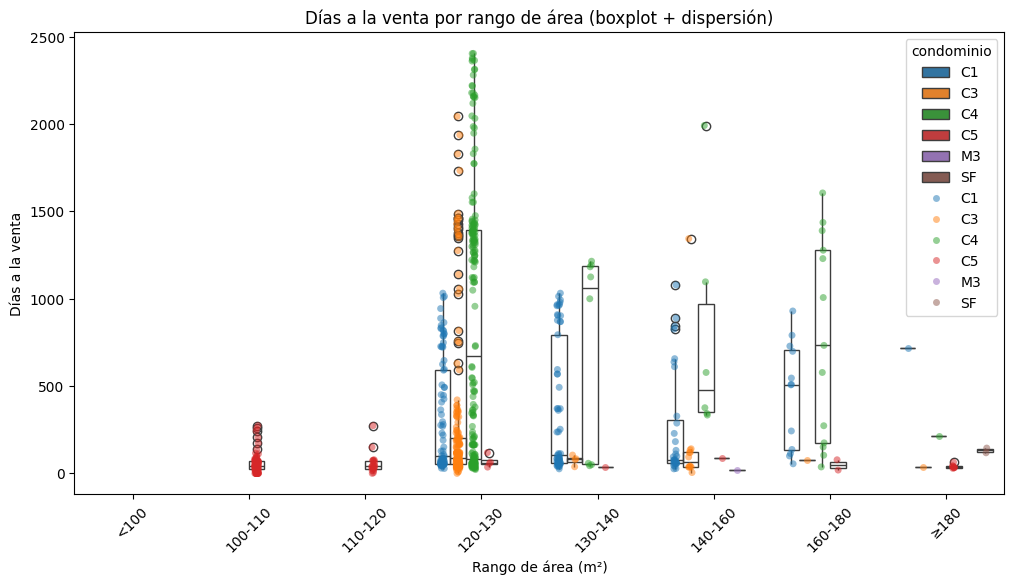

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=ventas, x="rango_area_m2", y="dias_a_la_venta", hue="condominio", showcaps=False, boxprops={'facecolor':'None'})
sns.stripplot(data=ventas, x="rango_area_m2", y="dias_a_la_venta", hue="condominio", dodge=True, jitter=True, alpha=0.5)
plt.title("Días a la venta por rango de área (boxplot + dispersión)")
plt.ylabel("Días a la venta")
plt.xlabel("Rango de área (m²)")
plt.xticks(rotation=45)
plt.show()


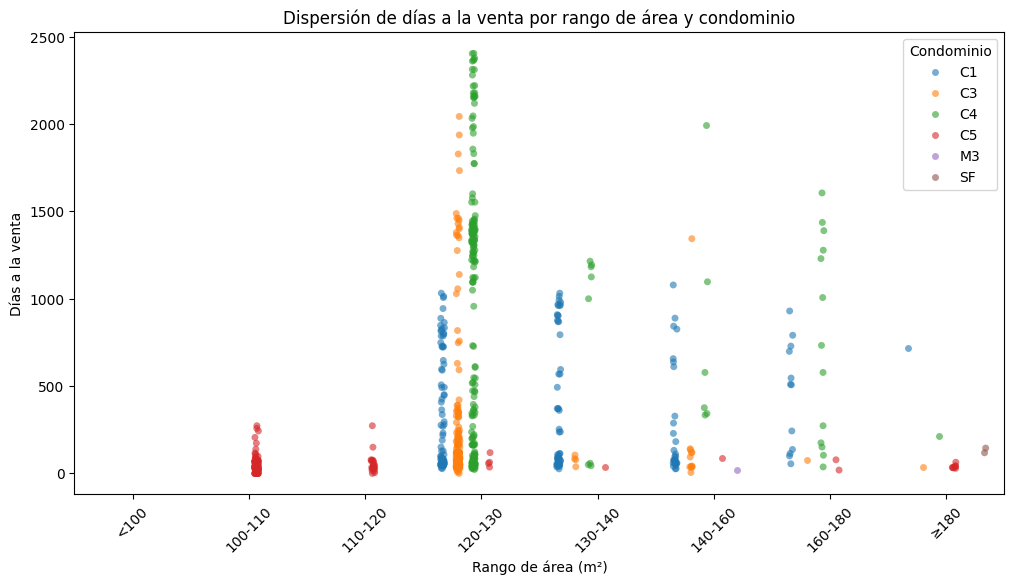

In [24]:
plt.figure(figsize=(12,6))
sns.stripplot(data=ventas, x="rango_area_m2", y="dias_a_la_venta", hue="condominio", dodge=True, jitter=True, alpha=0.6)
plt.title("Dispersión de días a la venta por rango de área y condominio")
plt.ylabel("Días a la venta")
plt.xlabel("Rango de área (m²)")
plt.xticks(rotation=45)
plt.legend(title="Condominio")
plt.show()


In [ ]:

def _ensure_datetime(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")  # datetime64[ns]

def _coerce_parquet_friendly(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) IDs y campos de texto típicos → string (no 'object')
    text_like = [c for c in ["condominio","lote_id","lote","estatus"] if c in df.columns]
    for c in text_like:
        df[c] = df[c].astype("string")  # Pandas StringDtype (acepta NA)

    # 2) Categóricas → string (evita problemas de categorías vacías)
    for c in df.select_dtypes(include=["category"]).columns:
        df[c] = df[c].astype("string")

    # 3) Objetos 'raros' (mezcla de tipos) → string salvo que sean todos números/fechas
    for c in df.columns:
        if df[c].dtype == "object":
            # si toda la columna es numérica "parseable", pásala a float
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().sum() == df[c].notna().sum() and df[c].notna().sum() > 0:
                df[c] = s
                continue
            # si parece fecha, normaliza a datetime
            d = pd.to_datetime(df[c], errors="coerce")
            if d.notna().sum() >= max(5, int(0.8 * df[c].notna().sum())):  # heurística
                df[c] = d
                continue
            # en cualquier otro caso, string
            df[c] = df[c].astype("string")

    # 4) Fechas tipo 'date' (python) → datetime64[ns]
    for c in df.columns:
        if df[c].dtype == "object" and df[c].apply(lambda x: hasattr(x, "year") and hasattr(x, "month") and hasattr(x, "day")).any():
            df[c] = pd.to_datetime(df[c], errors="coerce")

    return df

# === Aplica a tus DF ===
info_veredas_completo = _coerce_parquet_friendly(info_veredas_completo)
ventas = _coerce_parquet_friendly(ventas)
try:
    perfil = _coerce_parquet_friendly(perfil)
except NameError:
    perfil = None

# Normaliza fechas conocidas en ventas (por si venían como date)
date_cols_ventas = ["fecha_de_firma","fecha_apartado","fecha_pago_enganche","fecha_1era_mensualidad","fecha_fin_cobranza"]
_ensure_datetime(ventas, date_cols_ventas)

# Exporta ahora sí
ruta_base = "C:/Users/julio/OneDrive/Documentos/Trabajo/Ideas Frescas/Proyectos/Veredas/"
info_veredas_completo.to_parquet(ruta_base + "info.parquet", index=False)
ventas.to_parquet(ruta_base + "ventas.parquet", index=False)
if perfil is not None:
    perfil.to_parquet(ruta_base + "perfil.parquet", index=False)

print("✓ Exportado a Parquet sin errores.")


In [ ]:
# ------- EDA inicial ------- #
info_veredas_completo.describe(include="all").transpose()

In [ ]:
# ===== Distribución de Superficies - Versión Senior =====
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# -----------------------------
# 1) Preparar datos
# -----------------------------
df_sup = info_veredas_completo.copy()

# Asegurar tipo numérico y eliminar NaN o negativos
df_sup["m2"] = pd.to_numeric(df_sup["m2"], errors="coerce")
df_sup = df_sup[df_sup["m2"] > 0].dropna(subset=["m2"])

# -----------------------------
# 2) Resumen estadístico
# -----------------------------
resumen_sup = df_sup["m2"].describe(percentiles=[0.25, 0.5, 0.75]).to_frame(name="Superficie (m²)")
print("\n📏 Resumen estadístico de superficies:")
print(resumen_sup)

# -----------------------------
# 3) Histograma + KDE
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.histplot(
    df_sup["m2"],
    bins=20, kde=True, color="#1f77b4", ax=ax
)

# Línea de referencia en la mediana
mediana_m2 = df_sup["m2"].median()
ax.axvline(mediana_m2, color="red", linestyle="--", linewidth=1.5, label=f"Mediana: {mediana_m2:,.2f} m²")

# -----------------------------
# 4) Formato profesional
# -----------------------------
ax.set_title("Distribución de superficies de lotes", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Superficie (m²)")
ax.set_ylabel("Cantidad de lotes")
ax.legend()
ax.grid(axis="y", linestyle=":", alpha=0.6)

# Guardar en alta resolución
#plt.savefig("distribucion_superficies.png", dpi=300)
plt.show()


In [ ]:
# Calcular diferencia (solo tendrá sentido en filas de vendidos si quieres comparar)
info_veredas_completo["precio_m2_diff"] = info_veredas_completo["precio_m2_lista"] - info_veredas_completo["precio_m2_venta"]

# Resumen estadístico
info_veredas_completo[["precio_m2_lista", "precio_m2_venta", "precio_m2_diff"]].describe()


In [ ]:
# ===== Análisis de Descuentos - Versión Senior =====
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# -----------------------------
# 1) Preparar datos
# -----------------------------
ventas_proc = ventas.copy()

# Asegurar tipo numérico y eliminar NaN
ventas_proc["descuento"] = pd.to_numeric(ventas_proc["descuento"], errors="coerce")
ventas_proc = ventas_proc.dropna(subset=["descuento"])

# -----------------------------
# 2) Resumen estadístico
# -----------------------------
resumen = ventas_proc["descuento"].describe(percentiles=[0.25, 0.5, 0.75]).to_frame(name="Descuento (%)")
print("\n📊 Resumen estadístico de descuentos:")
print(resumen)

# -----------------------------
# 3) Histograma y KDE
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.histplot(
    ventas_proc["descuento"],
    bins=20, kde=True, color="#2a9d8f", ax=ax
)

# Línea de referencia en 0% y mediana
mediana_desc = ventas_proc["descuento"].median()
ax.axvline(0, color="red", linestyle="--", label="Sin descuento")
ax.axvline(mediana_desc, color="blue", linestyle="--", label=f"Mediana: {mediana_desc:.2f}%")

# -----------------------------
# 4) Formato y presentación
# -----------------------------
ax.set_title("Distribución de descuentos aplicados", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Descuento (%)")
ax.set_ylabel("Cantidad de lotes")
ax.legend()
ax.grid(axis="y", linestyle=":", alpha=0.6)

#plt.savefig("distribucion_descuentos.png", dpi=300)
plt.show()


In [ ]:
# ===== Absorción (ventas por mes)  =====
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# -----------------------------
# 1) Preparar datos
# -----------------------------
ventas_proc = ventas.copy()

# Tipar fecha_de_firma, ignorando valores inválidos
ventas_proc["mes_venta"] = pd.to_datetime(
    ventas_proc["fecha_de_firma"], errors="coerce"
).dt.to_period("M")

# Eliminar filas sin fecha válida
ventas_proc = ventas_proc.dropna(subset=["mes_venta"])

# -----------------------------
# 2) Calcular absorción mensual
# -----------------------------
abs_mes = (
    ventas_proc.groupby("mes_venta")["lote_id"]
    .nunique()  # ventas únicas por mes
    .reset_index(name="ventas_mes")
    .sort_values("mes_venta")
)

# Convertir Period → datetime para graficar en eje X
abs_mes["mes_venta_dt"] = abs_mes["mes_venta"].dt.to_timestamp()

# -----------------------------
# 3) Graficar línea
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
sns.lineplot(
    data=abs_mes,
    x="mes_venta_dt", y="ventas_mes",
    marker="o", linewidth=2, ax=ax
)

# Etiquetas sobre puntos
for x, y in zip(abs_mes["mes_venta_dt"], abs_mes["ventas_mes"]):
    ax.text(x, y + 0.3, f"{y}", ha="center", fontsize=8, color="#333")

# -----------------------------
# 4) Formato y contexto ejecutivo
# -----------------------------
ax.set_title(
    "Absorción mensual de ventas",
    fontsize=14, fontweight="bold", pad=10
)
ax.set_xlabel("Mes de venta")
ax.set_ylabel("Ventas únicas")
ax.grid(axis="y", linestyle=":", alpha=0.6)

# Subtítulo con KPIs
periodo = f"{abs_mes['mes_venta_dt'].min().strftime('%Y-%m')} – {abs_mes['mes_venta_dt'].max().strftime('%Y-%m')}"
total_ventas = abs_mes["ventas_mes"].sum()
promedio = abs_mes["ventas_mes"].mean()
ax.set_title(
    f"Absorción mensual de ventas\nPeriodo: {periodo} • Total: {total_ventas} • Promedio: {promedio:.1f}/mes",
    fontsize=10, pad=28
)

#plt.savefig("absorcion_mensual.png", dpi=300)
plt.show()


## **A) Análisis de precios**

1. **Distribución de precio m² por estatus**

   * Boxplots `precio_m2_lista` vs `precio_m2_venta` para ver la dispersión y si hay sesgo por descuentos.
   * Violin plots para ver la densidad.

2. **Mapa de calor** de precio m² por condominio y tamaño de lote (bin de m²).

   * Esto ayuda a detectar qué combinaciones son más caras o más baratas.

3. **Descuento relativo**

   * `((precio_m2_venta - precio_m2_lista) / precio_m2_lista) * 100`
   * Distribución de descuentos y si varían por condominio o tamaño.

4. **Ranking de condominios por precio promedio y mediana**

   * Comparar medianas para quitar el efecto de outliers.


In [ ]:
# ==== Distribución de precio m² por estatus ==== #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

df = info_veredas_completo.copy()

# 1) Limpieza mínima: quitar nulos y estatus vacíos
df = df.dropna(subset=["precio_m2_lista", "estatus"])
df = df[df["estatus"].astype(str).str.len() > 0]

# 2) Ordenar categorías por mediana (de mayor a menor)
stats = (df.groupby("estatus")["precio_m2_lista"]
           .agg(mediana="median", promedio="mean", n="count")
           .sort_values("mediana", ascending=False))
order = stats.index.tolist()
df["estatus"] = pd.Categorical(df["estatus"], categories=order, ordered=True)

# 3) Preparar figura
fig, ax = plt.subplots(figsize=(11, 6), constrained_layout=True)

# 4) Boxplot (sin outliers para no “ensuciar”)
bp = ax.boxplot(
    [df.loc[df["estatus"]==cat, "precio_m2_lista"].values for cat in order],
    vert=True, patch_artist=True, showfliers=False, widths=0.55
)

# Dar un tono neutro a las cajas (sin colores específicos llamativos)
for box in bp["boxes"]:
    box.set(facecolor="#e6e6e6", edgecolor="#666666", linewidth=1)
for element in ["whiskers","caps","medians"]:
    for line in bp[element]:
        line.set(color="#666666", linewidth=1)

# 5) Overlay de medias (◇) y anotaciones de mediana
for i, cat in enumerate(order, start=1):
    serie = df.loc[df["estatus"]==cat, "precio_m2_lista"]
    med = np.median(serie)
    mean = np.mean(serie)
    n = serie.shape[0]

    # Media como rombo
    ax.plot(i, mean, marker='D', markersize=6, color="red", linestyle='None')


    # Etiqueta de mediana encima de la caja
    ax.text(i, med, f"{med:,.0f}", ha="center", va="bottom", fontsize=9)

    # Etiqueta de N en el eje X
    ax.text(i, ax.get_ylim()[0], f"N={n}", ha="center", va="bottom", fontsize=8, rotation=0)

# 6) Línea de referencia global (mediana del total)
global_med = df["precio_m2_lista"].median()
ax.axhline(global_med, linestyle="--", linewidth=1, alpha=0.8)
ax.text(0.48, global_med, f"Mediana global: {global_med:,.0f}", va="bottom", ha="left", fontsize=9)

# 7) Ejes y formato monetario
ax.set_xticks(range(1, len(order)+1))
ax.set_xticklabels(order, rotation=0)
ax.set_xlabel("Estatus", labelpad=8)
ax.set_ylabel("Precio por m²")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))

# 8) Títulos jerárquicos (título + subtítulo con fecha y notas)
fig.suptitle("Distribución de precio de lista por m², por estatus", fontsize=14, fontweight="bold", y=1.02)
ax.set_title("Cajas ordenadas por mediana • ◇ = promedio • línea punteada = mediana global", fontsize=10, pad=8)

# 9) Rejilla ligera
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")


# 11) Exportar en alta resolución (para reportes)
#plt.savefig("distribucion_precio_m2_por_estatus.png", dpi=300)
#plt.savefig("distribucion_precio_m2_por_estatus.svg")  # vectorial para ppt
plt.show()


In [ ]:
# 1) Limpieza mínima: quitar nulos y estatus vacíos
df = info_veredas_completo.copy()

df = df.dropna(subset=["precio_m2_venta", "estatus"])
df = df[df["estatus"].astype(str).str.len() > 0]

# 2) Ordenar categorías por mediana (de mayor a menor)
stats = (df.groupby("estatus")["precio_m2_venta"]
           .agg(mediana="median", promedio="mean", n="count")
           .sort_values("mediana", ascending=False))
order = stats.index.tolist()
df["estatus"] = pd.Categorical(df["estatus"], categories=order, ordered=True)

# 3) Preparar figura
fig, ax = plt.subplots(figsize=(11, 6), constrained_layout=True)

# 4) Boxplot (sin outliers para no “ensuciar”)
bp = ax.boxplot(
    [df.loc[df["estatus"]==cat, "precio_m2_venta"].values for cat in order],
    vert=True, patch_artist=True, showfliers=False, widths=0.55
)

# Dar un tono neutro a las cajas (sin colores específicos llamativos)
for box in bp["boxes"]:
    box.set(facecolor="#e6e6e6", edgecolor="#666666", linewidth=1)
for element in ["whiskers","caps","medians"]:
    for line in bp[element]:
        line.set(color="#666666", linewidth=1)

# 5) Overlay de medias (◇) y anotaciones de mediana
for i, cat in enumerate(order, start=1):
    serie = df.loc[df["estatus"]==cat, "precio_m2_venta"]
    med = np.median(serie)
    mean = np.mean(serie)
    n = serie.shape[0]

    # Media como rombo
    ax.plot(i, mean, marker='D', markersize=6, color="red", linestyle='None')


    # Etiqueta de mediana encima de la caja
    ax.text(i, med, f"{med:,.0f}", ha="center", va="bottom", fontsize=9)

    # Etiqueta de N en el eje X
    ax.text(i, ax.get_ylim()[0], f"N={n}", ha="center", va="bottom", fontsize=8, rotation=0)

# 6) Línea de referencia global (mediana del total)
global_med = df["precio_m2_venta"].median()
ax.axhline(global_med, linestyle="--", linewidth=1, alpha=0.8)
ax.text(0.48, global_med, f"Mediana global: {global_med:,.0f}", va="bottom", ha="left", fontsize=9)

# 7) Ejes y formato monetario
ax.set_xticks(range(1, len(order)+1))
ax.set_xticklabels(order, rotation=0)
ax.set_xlabel("Estatus", labelpad=8)
ax.set_ylabel("Precio por m²")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))

# 8) Títulos jerárquicos (título + subtítulo con fecha y notas)
fig.suptitle("Distribución de precio de venta por m², por estatus", fontsize=14, fontweight="bold", y=1.02)
ax.set_title("Cajas ordenadas por mediana • ◇ = promedio • línea punteada = mediana global", fontsize=10, pad=8)

# 9) Rejilla ligera
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")


# 11) Exportar en alta resolución (para reportes)
#plt.savefig("distribucion_precio_m2_por_estatus.png", dpi=300)
#plt.savefig("distribucion_precio_m2_por_estatus.svg")  # vectorial para ppt
plt.show()

In [ ]:
# ==== Mapa de calor ==== #
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

matplotlib.rcParams['font.family'] = 'DejaVu Sans'

df = info_veredas_completo.copy()

# Limpieza mínima
df = df.dropna(subset=["m2", "estatus"])
df["precio_m2_general"] = np.where(
    df["estatus"].eq("Disponible"),
    df["precio_m2_lista"],
    df["precio_m2_venta"]
)
df = df.dropna(subset=["precio_m2_general"])

# Segmentar por tamaño
bins = [0, 120, 140, 160, np.inf]
labels = ["<120 m²", "120–140 m²", "140–160 m²", ">160 m²"]
df["segmento_m2"] = pd.cut(df["m2"], bins=bins, labels=labels, include_lowest=True, ordered=True)

# Ordenar estatus por mediana
medianas_estatus = df.groupby("estatus")["precio_m2_general"].median().sort_values(ascending=False)
estatus_order = medianas_estatus.index.tolist()
df["estatus"] = pd.Categorical(df["estatus"], categories=estatus_order, ordered=True)

# Pivot con observed=False explícito
heat_mean = df.pivot_table(
    index="segmento_m2", columns="estatus",
    values="precio_m2_general", aggfunc="mean", observed=False
)
heat_n = df.pivot_table(
    index="segmento_m2", columns="estatus",
    values="precio_m2_general", aggfunc="count", observed=False
).fillna(0).astype(int)

# Anotaciones: "$X,XXX\nn=Y"
annot = heat_mean.copy()
annot = annot.map(lambda v: "" if pd.isna(v) else f"${v:,.0f}")
annot = annot + "\n" + heat_n.astype(str).radd("n=")

# Escala robusta
vals = heat_mean.to_numpy().flatten()
vals = vals[~np.isnan(vals)]
if len(vals) > 0:
    vmin, vmax = np.percentile(vals, [5, 95])
else:
    vmin, vmax = None, None

# Graficar
plt.figure(figsize=(9.5, 6.5))
ax = sns.heatmap(
    heat_mean,
    annot=annot, fmt="",
    cmap="viridis",
    linewidths=0.5, linecolor="white",
    cbar=True, vmin=vmin, vmax=vmax
)

# Colorbar
cbar = ax.collections[0].colorbar
cbar.formatter = FuncFormatter(lambda x, pos: f"${x:,.0f}")
cbar.update_ticks()
cbar.set_label("Precio promedio por m²", rotation=90)

# Títulos
plt.suptitle("Mapa de calor: Precio promedio por m²", fontsize=14, fontweight="bold", y=1.02)
ax.set_title("Segmentado por tamaño de lote y estatus • Celdas: $promedio + n de observaciones",
             fontsize=10, pad=8)
ax.set_xlabel("Estatus")
ax.set_ylabel("Segmento de m²")
ax.tick_params(axis='x', labelrotation=0)
ax.tick_params(axis='y', labelrotation=0)

plt.tight_layout()
#plt.savefig("heatmap_precio_m2_sin_warnings.png", dpi=300)
#plt.savefig("heatmap_precio_m2_sin_warnings.svg")
plt.show()



**Qué muestra este gráfico**

* Filas → Segmentos de tamaño de lote.
* Columnas → Estatus (Disponible / Vendido).
* Celdas → Precio m² promedio.
* Colores → Tonos más claros = precios más altos.



In [ ]:
# ==== Descuento relativo ==== #
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 0) Estilo y fuente (evita warnings de símbolos)
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

df = info_veredas_completo.copy()

# 1) Cálculo robusto del descuento solo para vendidos, evitando divisiones raras
df = df.dropna(subset=["estatus", "precio_m2_lista", "precio_m2_venta"])
df["descuento_pct"] = np.where(
    df["estatus"].eq("Vendido") & (df["precio_m2_lista"] > 0),
    100 * (df["precio_m2_venta"] / df["precio_m2_lista"] - 1.0),
    np.nan
)

# 2) Winsorización suave para evitar que outliers “aplasten” la lectura del hist y cajas
vend = df.loc[df["estatus"].eq("Vendido"), ["descuento_pct", "condominio", "m2"]].dropna()
if not vend["descuento_pct"].empty:
    p1, p99 = np.percentile(vend["descuento_pct"], [1, 99])
    vend["descuento_pct_clip"] = vend["descuento_pct"].clip(p1, p99)
else:
    vend["descuento_pct_clip"] = vend["descuento_pct"]

# 3) Segmentos de m² limpios/ordenados
bins = [0, 120, 140, 160, np.inf]
labels = ["<120 m²", "120–140 m²", "140–160 m²", ">160 m²"]
vend["segmento_m2"] = pd.cut(vend["m2"], bins=bins, labels=labels, include_lowest=True, ordered=True)

# 4) ---------- HISTOGRAMA + KDE (distribución global) ----------
fig, ax = plt.subplots(figsize=(9.5, 5.5), constrained_layout=True)
sns.histplot(
    data=vend,
    x="descuento_pct_clip",
    bins=30,
    kde=True,
    line_kws={"linewidth": 1.2},
    ax=ax
)

# Líneas de referencia y métricas clave
median = vend["descuento_pct"].median()
mean = vend["descuento_pct"].mean()
ax.axvline(0, color="red", linestyle="--", linewidth=1, label="0% (sin descuento)")
ax.axvline(median, color="black", linestyle="-", linewidth=1, label=f"Mediana: {median:,.1f}%")
ax.axvline(mean, color="black", linestyle=":", linewidth=1, label=f"Media: {mean:,.1f}%")

# Share de descuentos vs incrementos
neg = (vend["descuento_pct"] < 0).mean()
zer = (vend["descuento_pct"] == 0).mean()
pos = (vend["descuento_pct"] > 0).mean()
n = vend.shape[0]
ax.text(0.98, 0.97,
        f"n={n}\nDescuento: {neg:,.0%}\nSin cambio: {zer:,.0%}\nAumento: {pos:,.0%}",
        transform=ax.transAxes, ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#cccccc"))

ax.set_title("Distribución del descuento relativo en lotes vendidos\n(Winsor 1–99% para lectura estable)", fontsize=12, fontweight="bold", pad=8)
ax.set_xlabel("Descuento relativo (%)")
ax.set_ylabel("Cantidad de lotes")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}%"))
ax.legend(frameon=True)

#plt.savefig("hist_descuento_relativo.png", dpi=300)
#plt.savefig("hist_descuento_relativo.svg")
plt.show()

# 5) ---------- BOXPLOT POR CONDOMINIO ----------
# Ordenar condominios por mediana de descuento (desc)


In [ ]:
# 5) ---------- BOXPLOT POR CONDOMINIO ----------
# Ordenar condominios por mediana de descuento (desc)
medianas_condo = vend.groupby("condominio")["descuento_pct"].median().sort_values(ascending=False)
order_condo = medianas_condo.index.tolist()

fig, ax = plt.subplots(figsize=(10.5, 5.5), constrained_layout=True)
sns.boxplot(
    data=vend.assign(condominio=pd.Categorical(vend["condominio"], categories=order_condo, ordered=True)),
    x="condominio", y="descuento_pct_clip",
    showfliers=False, width=0.55, ax=ax
)

# Línea 0% y formato
ax.axhline(0, color="red", linestyle="--", linewidth=1)
ax.set_title("Descuento relativo (%) por condominio (ordenado por mediana)", fontsize=12, fontweight="bold", pad=8)
ax.set_xlabel("Condominio")
ax.set_ylabel("Descuento relativo (%)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}%"))
ax.tick_params(axis='x', rotation=0)

# Mediana y N por categoría
ymin, ymax = ax.get_ylim()
for i, c in enumerate(order_condo):
    serie = vend.loc[vend["condominio"] == c, "descuento_pct"]
    if serie.empty: 
        continue
    med = serie.median()
    n_c = serie.shape[0]
    # Etiqueta de mediana
    ax.text(i, med, f"{med:,.1f}%", ha="center", va="bottom", fontsize=9)
    # N al pie
    ax.text(i, ymin, f"n={n_c}", ha="center", va="bottom", fontsize=8)

#plt.savefig("box_descuento_por_condominio.png", dpi=300)
#plt.savefig("box_descuento_por_condominio.svg")
plt.show()

In [ ]:
# 6) ---------- BOXPLOT POR SEGMENTO DE M² ----------
# Ordenar segmentos por mediana de descuento (desc) para lectura ejecutiva
medianas_seg = vend.groupby("segmento_m2")["descuento_pct"].median().sort_values(ascending=False)
order_seg = medianas_seg.index.tolist()

fig, ax = plt.subplots(figsize=(9.5, 5.5), constrained_layout=True)
sns.boxplot(
    data=vend.assign(segmento_m2=pd.Categorical(vend["segmento_m2"], categories=order_seg, ordered=True)),
    x="segmento_m2", y="descuento_pct_clip",
    showfliers=False, width=0.55, ax=ax
)

ax.axhline(0, color="red", linestyle="--", linewidth=1)
ax.set_title("Descuento relativo (%) por segmento de tamaño de lote (ordenado por mediana)", fontsize=12, fontweight="bold", pad=8)
ax.set_xlabel("Segmento de m²")
ax.set_ylabel("Descuento relativo (%)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}%"))
ax.tick_params(axis='x', rotation=0)

# Mediana y N por segmento
ymin, ymax = ax.get_ylim()
for i, s in enumerate(order_seg):
    serie = vend.loc[vend["segmento_m2"] == s, "descuento_pct"]
    if serie.empty:
        continue
    med = serie.median()
    n_s = serie.shape[0]
    ax.text(i, med, f"{med:,.1f}%", ha="center", va="bottom", fontsize=9)
    ax.text(i, ymin, f"n={n_s}", ha="center", va="bottom", fontsize=8)

#plt.savefig("box_descuento_por_segmento.png", dpi=300)
#plt.savefig("box_descuento_por_segmento.svg")
plt.show()


1. Histograma con distribución general de descuentos.
2. Boxplot por condominio para ver variaciones.
3. Boxplot por segmentos de tamaño de lote para ver tendencias.



In [ ]:
# ==== Ranking de condominios por precio promedio y mediana ==== #

# 1. Crear columna unificada de precio_m2
info_veredas_completo["precio_m2_general"] = info_veredas_completo.apply(
    lambda row: row["precio_m2_lista"] if row["estatus"]=="Disponible" else row["precio_m2_venta"],
    axis=1
)

# 2. Agrupar por condominio y calcular métricas
ranking_condominios = info_veredas_completo.groupby("condominio").agg(
    precio_m2_promedio = ("precio_m2_general", "mean"),
    precio_m2_mediana  = ("precio_m2_general", "median"),
    conteo_lotes       = ("lote_id", "count")
).reset_index()

# 3. Ordenar por mediana descendente
ranking_condominios = ranking_condominios.sort_values(by="precio_m2_mediana", ascending=False)

# 4. Mostrar tabla
print(ranking_condominios)

# 5. Visualización: comparación promedio vs mediana
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
ranking_condominios.plot(
    x="condominio",
    y=["precio_m2_promedio", "precio_m2_mediana"],
    kind="bar",
    figsize=(10,6)
)
plt.title("Ranking de condominios por precio m² (Promedio vs Mediana)")
plt.ylabel("Precio m²")
plt.xlabel("Condominio")
plt.xticks(rotation=45)
plt.legend(["Promedio", "Mediana"])
plt.tight_layout()
plt.show()




* **Tabla** con precio m² promedio, mediana y conteo de lotes por condominio.
* **Gráfico de barras** comparando promedio y mediana, para detectar si hay outliers inflando el promedio.



 **Efecto de outliers**

* El **promedio** y la **mediana** están bastante cercanos en casi todos los casos → No parece haber muchos outliers extremos inflando precios.









## **B) Análisis de absorción**

5. **Tiempo de venta** (si tienes fecha de publicación y venta)

   * Histograma de días hasta la venta.
   * Comparar tiempos entre segmentos de precio o m².

6. **Curva de absorción acumulada**

   * Lotes vendidos por mes acumulados vs inventario total.

7. **Tasa de absorción por condominio**

   * (# vendidos por mes) / (inventario inicial en ese condominio).
   * Esto revela dónde rota más rápido.

8. **Estacionalidad de ventas**

   * Promediar ventas por mes/año para ver si hay picos en ciertos meses.





In [ ]:
# ===== Tiempo de venta ===== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1) Preparación de fechas
# -----------------------------
ventas = ventas.copy()

# Parseo de fechas relevantes
for c in ["fecha_de_firma","fecha_apartado"]:
    ventas[c] = pd.to_datetime(ventas[c], errors="coerce")

# fecha_publicacion = mín(fecha_apartado) por lote_id
pub_por_lote = (ventas
                .groupby("lote_id", as_index=False)["fecha_apartado"]
                .min()
                .rename(columns={"fecha_apartado":"fecha_publicacion"}))

ventas = ventas.merge(pub_por_lote, on="lote_id", how="left")

# -----------------------------
# 2) Días hasta la venta
# -----------------------------
vendidos = ventas[
    (ventas["estatus"]=="Vendido")
    & ventas["fecha_de_firma"].notna()
    & ventas["fecha_publicacion"].notna()
].copy()

vendidos["dias_venta"] = (vendidos["fecha_de_firma"] - vendidos["fecha_publicacion"]).dt.days

# Limpieza: descartar negativos/anómalos si existen
vendidos = vendidos[vendidos["dias_venta"] >= 0]

print("Resumen días_venta:\n", vendidos["dias_venta"].describe())

# -----------------------------
# 3) Histograma días hasta la venta
# -----------------------------
plt.figure(figsize=(10,5))
sns.histplot(vendidos["dias_venta"], bins=30, kde=False)
plt.axvline(vendidos["dias_venta"].median(), color="red", linestyle="--",
            label=f"Mediana: {int(vendidos['dias_venta'].median())} días")
plt.title("Distribución de días desde publicación (min fecha_apartado) hasta la venta")
plt.xlabel("Días hasta la venta")
plt.ylabel("Cantidad de lotes")
plt.legend()
plt.show()

# -----------------------------
# 4) Segmentos de PRECIO m² (venta) → boxplot de días_venta
# -----------------------------
# Si no existe, asegúrate de tener precio_m2_venta (real)
bins_precio = [0, 4000, 6000, 8000, np.inf]
labels_precio = ["<4,000", "4,000–6,000", "6,000–8,000", ">8,000"]
vendidos["segmento_precio_m2"] = pd.cut(vendidos["precio_m2_venta"], bins=bins_precio, labels=labels_precio)

plt.figure(figsize=(10,5))
sns.boxplot(data=vendidos, x="segmento_precio_m2", y="dias_venta", showfliers=False)
plt.title("Tiempo de venta por segmento de precio m² (venta)")
plt.xlabel("Segmento de precio m² (venta)")
plt.ylabel("Días hasta la venta")
plt.show()

# Resumen numérico por segmento de precio
print(
    vendidos.groupby("segmento_precio_m2")["dias_venta"]
    .agg(["count","median","mean","std"])
    .rename(columns={"count":"n"})
)

# -----------------------------
# 5) Segmentos de TAMAÑO (m²) → boxplot de días_venta
# -----------------------------
bins_m2 = [0, 120, 140, 160, np.inf]
labels_m2 = ["<120 m²", "120–140 m²", "140–160 m²", ">160 m²"]
vendidos["segmento_m2"] = pd.cut(vendidos["area_m2"], bins=bins_m2, labels=labels_m2)

plt.figure(figsize=(10,5))
sns.boxplot(data=vendidos, x="segmento_m2", y="dias_venta", showfliers=False)
plt.title("Tiempo de venta por segmento de tamaño de lote")
plt.xlabel("Segmento de m²")
plt.ylabel("Días hasta la venta")
plt.show()

# Resumen numérico por segmento de m²
print(
    vendidos.groupby("segmento_m2")["dias_venta"]
    .agg(["count","median","mean","std"])
    .rename(columns={"count":"n"})
)

# -----------------------------
# 6) (Opcional) Cruces por condominio
# -----------------------------
res_condo = (
    vendidos.groupby("condominio")["dias_venta"]
    .agg(["count","median","mean","std"])
    .rename(columns={"count":"n"})
    .sort_values("median")
)
print("\nTiempo de venta por condominio (ordenado por mediana):\n", res_condo.head(10))



In [ ]:
# ===== Curva acumulada + Ritmo medio anual (fix warnings) =====
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

matplotlib.rcParams['font.family'] = 'DejaVu Sans'

inv = info_veredas_completo.copy()

# Tipar fecha_de_firma, ignorando valores inválidos
ventas["mes_venta"] = pd.to_datetime(
    ventas["fecha_de_firma"], errors="coerce"
).dt.to_period("M")

vent = ventas.copy()
# --- Fechas robustas ---
vent = vent.dropna(subset=["estatus", "lote_id", "mes_venta"])

# ✅ Fix deprecación: detectar PeriodDtype sin is_period_dtype
if isinstance(vent["mes_venta"].dtype, pd.PeriodDtype):
    vent["mes_venta"] = vent["mes_venta"].dt.to_timestamp(how="start")
else:
    vent["mes_venta"] = pd.to_datetime(vent["mes_venta"], errors="coerce").dt.to_period("M").dt.to_timestamp(how="start")

vent = vent.sort_values(["lote_id", "mes_venta"])

# Primera venta por lote (evita doble conteo)
primera_venta = (
    vent[vent["estatus"].eq("Vendido")]
    .groupby("lote_id", as_index=False)["mes_venta"].min()
)

# Conteo mensual y reindexado continuo
if primera_venta.empty:
    vendidos_mes = pd.DataFrame(columns=["mes_venta","lotes_vendidos","acumulado_vendidos"])
else:
    vendidos_mes = (primera_venta
        .groupby("mes_venta")["lote_id"].nunique()
        .rename("lotes_vendidos")
        .to_frame()
        .sort_index()
    )
    full_idx = pd.date_range(vendidos_mes.index.min(), vendidos_mes.index.max(), freq="MS")
    vendidos_mes = vendidos_mes.reindex(full_idx, fill_value=0)
    vendidos_mes.index.name = "mes_venta"
    vendidos_mes = vendidos_mes.reset_index()

# Inventario total
inventario_total = inv["lote_id"].nunique()

# Acumulado
if not vendidos_mes.empty:
    vendidos_mes["acumulado_vendidos"] = vendidos_mes["lotes_vendidos"].cumsum()
else:
    vendidos_mes["acumulado_vendidos"] = []

# Ritmo medio (lotes/mes) por año
if not vendidos_mes.empty:
    year_avg = (vendidos_mes
                .assign(year=vendidos_mes["mes_venta"].dt.year)
                .groupby("year")["lotes_vendidos"]
                .mean())
else:
    year_avg = pd.Series(dtype=float)

# Posición de barras: ~mitad de año
x_years = (pd.to_datetime(year_avg.index.astype(str)) + pd.offsets.MonthBegin(7)) if len(year_avg) else pd.to_datetime([])

# ===== Gráfica (solo constrained_layout; NO tight_layout) =====
fig, ax1 = plt.subplots(figsize=(11, 6.5), constrained_layout=True)

if not vendidos_mes.empty:
    x = vendidos_mes["mes_venta"]

    # Lotes acumulados
    l1, = ax1.plot(x, vendidos_mes["acumulado_vendidos"],
                   marker="o", linewidth=2, label="Lotes vendidos acumulados")

    # Inventario total
    ax1.axhline(inventario_total, color="#888888", linestyle="--", linewidth=1)
    ax1.text(x.iloc[0], inventario_total, f" Inventario total: {inventario_total}",
             va="bottom", ha="left", fontsize=9, color="#555555")

    # Sombreado inventario restante
    ax1.fill_between(x, vendidos_mes["acumulado_vendidos"], inventario_total,
                     alpha=0.12, label="Inventario restante (estimado)")

    ax1.set_ylabel("Lotes vendidos acumulados")
    ax1.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    # Eje X formateado por meses
    tick_every = max(len(x) // 12, 1)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_every))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=0, ha="center")

    # Eje derecho: ritmo medio anual (barras)
    ax2 = ax1.twinx()
    if len(year_avg):
        bars = ax2.bar(x_years, year_avg.values, width=50,  # ancho en días aprox.
                       alpha=0.35, label="Ritmo medio anual (lotes/mes)")
        for rect, val in zip(bars, year_avg.values):
            ax2.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                     f"{val:,.1f}", ha="center", va="bottom", fontsize=9)

    ax2.set_ylabel("Ritmo medio (lotes/mes)")

    # Leyenda combinada
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = (ax2.get_legend_handles_labels() if len(year_avg) else ([], []))
    ax1.legend(lines + lines2, labels + labels2, loc="upper left", frameon=True)

# Títulos
fig.suptitle("Curva acumulada y ritmo medio anual de ventas", fontsize=14, fontweight="bold")
total_vendidos = int(vendidos_mes["acumulado_vendidos"].iloc[-1]) if not vendidos_mes.empty else 0
ritmo_global = vendidos_mes["lotes_vendidos"].mean() if not vendidos_mes.empty else 0.0
ax1.set_title(f"Total vendidos: {total_vendidos} de {inventario_total}  •  "
              f"Ritmo global: {ritmo_global:,.1f} lotes/mes  •  Barras = promedio anual de lotes/mes",
              fontsize=10, pad=8)

# Grid sutil
ax1.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax1.grid(False, axis="x")

# Exportar
#plt.savefig("curva_acumulada_y_ritmo_anual_fix.png", dpi=300)
#plt.savefig("curva_acumulada_y_ritmo_anual_fix.svg")
plt.show()


In [ ]:
# ====== Tasa de absorción mensual por condominio (versión senior) ===== #
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# --- 1) Filtrar vendidos ---
vendidos = ventas[ventas["estatus"] == "Vendido"].copy()

# Tipar fechas robustamente (mes_venta puede ser Period, string o datetime)
if isinstance(vendidos["mes_venta"].dtype, pd.PeriodDtype):
    vendidos["mes_venta"] = vendidos["mes_venta"].dt.to_timestamp(how="start")
else:
    vendidos["mes_venta"] = pd.to_datetime(vendidos["mes_venta"], errors="coerce").dt.to_period("M").dt.to_timestamp(how="start")

# --- 2) Inventario inicial por condominio ---
inventario_inicial = ventas.groupby("condominio")["lote_id"].nunique().to_dict()

# --- 3) Ventas mensuales por condominio ---
ventas_mes_condo = (
    vendidos.groupby(["condominio", "mes_venta"])["lote_id"]
    .nunique()
    .reset_index(name="lotes_vendidos")
    .sort_values("mes_venta")
)

# --- 4) Calcular tasa de absorción mensual ---
ventas_mes_condo["inventario_inicial"] = ventas_mes_condo["condominio"].map(inventario_inicial)
ventas_mes_condo["tasa_absorcion"] = ventas_mes_condo["lotes_vendidos"] / ventas_mes_condo["inventario_inicial"]

# --- 5) Resumen ejecutivo ---
resumen_tasa = (
    ventas_mes_condo.groupby("condominio")["tasa_absorcion"]
    .agg(promedio="mean", mediana="median", máximo="max")
    .sort_values("promedio", ascending=False)
)
print("\nResumen de tasa de absorción mensual (% del inventario inicial vendido cada mes):\n")
print((resumen_tasa * 100).round(2).astype(str) + " %")

# --- 6) Gráfico ---
fig, ax = plt.subplots(figsize=(11, 6.5), constrained_layout=True)

palette = sns.color_palette("tab10", n_colors=ventas_mes_condo["condominio"].nunique())

for (condo, color) in zip(resumen_tasa.index, palette):
    df_c = ventas_mes_condo[ventas_mes_condo["condominio"] == condo]
    ax.plot(df_c["mes_venta"], df_c["tasa_absorcion"],
            marker="o", linewidth=2, label=condo, color=color)
    # Etiqueta de último valor
    ax.text(df_c["mes_venta"].iloc[-1], df_c["tasa_absorcion"].iloc[-1],
            f"{df_c['tasa_absorcion'].iloc[-1]*100:,.1f}%",
            ha="left", va="center", fontsize=9)

# Ejes y formato
ax.set_title("Tasa de absorción mensual por condominio", fontsize=14, fontweight="bold", pad=8)
ax.set_xlabel("Mes de venta")
ax.set_ylabel("Tasa de absorción mensual (%)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:,.0f}%"))
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))

# Leyenda
ax.legend(title="Condominio", bbox_to_anchor=(1.05, 1), loc='upper left')

# Grid sutil
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")

# Exportar
#plt.savefig("tasa_absorcion_mensual_por_condominio.png", dpi=300)
#plt.savefig("tasa_absorcion_mensual_por_condominio.svg")
plt.show()




1. **Gráfico de líneas** → cada condominio con su serie de tasa de absorción mensual.
2. **Tabla resumen** → promedio, mediana y máximo de la tasa para identificar cuáles rotan más rápido.


**1. Condominios que rotan muy rápido**

* **M3** → tasa promedio, mediana y máxima = **1.0** → significa que vendió **todo su inventario en un solo mes** (posiblemente porque tenía muy pocos lotes y alta demanda).
  Esto puede indicar que fue un producto **muy atractivo o con precio muy competitivo**, o que estuvo sujeto a una venta interna/anticipada.

* **SF** → 0.5 constante → significa que en el mes que tuvo ventas, absorbió **la mitad de su inventario total**.
  Esto es altísimo y apunta a una rotación rápida, aunque no tan extrema como M3.

**2. Rotación moderada**

* **C5** → promedio ≈ 3.8% del inventario al mes, mediana ≈ 2.4%, con picos de ≈ 11.9%.
  Esto indica que se mueve, pero no a gran velocidad. Tiene potencial de mejorar con estrategias comerciales.

* **C3** y **C1** → promedios ≈ 2.6% y 2.5% respectivamente → rotación lenta.
  Aunque C3 llega a un pico de ≈ 16.9%, normalmente sus ventas mensuales son bajas en proporción a su inventario.

 **3. Rotación lenta**

* **C4** → el más bajo con ≈ 1.53% mensual promedio.
  Esto sugiere que hay **freno en la absorción**, quizás por precio, producto, ubicación o exceso de inventario.

 **4. Posibles causas y próximos pasos**

* **Alta absorción** (M3, SF) → podrían replicar estrategia de marketing/precio/amenidades en otros condominios.
* **Media-baja absorción** (C5, C3, C1, C4) → investigar:

  * Relación precio m² vs competidores internos.
  * Perfil del comprador (quizá no está bien segmentado).
  * Oferta de inventario (lotes menos atractivos o demasiado grandes/pequeños).
  * Momentos de lanzamiento y estacionalidad.




In [ ]:
# ===== Scatter ejecutivo: Precio m² vs Tasa de absorción (con leyenda unificada y etiquetas) =====
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter


# Estética y fuente robusta (evita issues de glyphs)
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# --- 0) Copia y supuestos mínimos ---
dfv = ventas.copy()  # en este DF son todos vendidos
# precio unificado (venta) — explícito
dfv["precio_m2_general"] = dfv["precio_m2_venta"]

# --- 1) Ranking de precio m² mediana por condominio ---
ranking_precio = (dfv
    .dropna(subset=["condominio","precio_m2_general"])
    .groupby("condominio", as_index=False)
    .agg(precio_m2_mediana=("precio_m2_general","median"))
)

# --- 2) Tasa de absorción promedio por condominio ---
# Usamos tu 'resumen_tasa' si ya existe; si no, lo calculamos rápido desde dfv (ventas mensuales / inventario inicial)
try:
    resumen_tasa_reset = resumen_tasa.reset_index()[["condominio", "promedio"]].rename(columns={"promedio":"tasa_abs_prom"})
except NameError:
    # Inventario inicial: lotes únicos por condominio (en todo el histórico)
    inventario_inicial = dfv.groupby("condominio")["lote_id"].nunique()
    # Asegurar fecha mensual
    if "mes_venta" in dfv.columns:
        if isinstance(dfv["mes_venta"].dtype, pd.PeriodDtype):
            dfv["mes_venta"] = dfv["mes_venta"].dt.to_timestamp(how="start")
        else:
            dfv["mes_venta"] = pd.to_datetime(dfv["mes_venta"], errors="coerce").dt.to_period("M").dt.to_timestamp(how="start")
    else:
        raise ValueError("Falta la columna 'mes_venta' para calcular la tasa de absorción.")
    ventas_mes_condo = (dfv
        .groupby(["condominio","mes_venta"])["lote_id"].nunique()
        .rename("lotes_vendidos").reset_index())
    ventas_mes_condo["inventario_inicial"] = ventas_mes_condo["condominio"].map(inventario_inicial)
    ventas_mes_condo["tasa_absorcion"] = ventas_mes_condo["lotes_vendidos"] / ventas_mes_condo["inventario_inicial"].replace(0, np.nan)
    resumen_tasa_reset = (ventas_mes_condo
        .groupby("condominio", as_index=False)["tasa_absorcion"]
        .mean().rename(columns={"tasa_absorcion":"tasa_abs_prom"}))

# --- 3) Contexto: inventario para escalar burbujas y total vendidos para etiquetar ---
inventario_condo = dfv.groupby("condominio")["lote_id"].nunique().rename("inventario_condo").reset_index()
vendidos_total = dfv.groupby("condominio")["lote_id"].nunique().rename("vendidos_total").reset_index()

# --- 4) Merge maestro ---
precio_vs_abs = (ranking_precio
    .merge(resumen_tasa_reset, on="condominio", how="inner")
    .merge(inventario_condo, on="condominio", how="left")
    .merge(vendidos_total, on="condominio", how="left")
    .dropna(subset=["precio_m2_mediana","tasa_abs_prom"])
)

# --- 5) Medianas globales y cuadrantes ---
mediana_precio = float(precio_vs_abs["precio_m2_mediana"].median())
mediana_abs = float(precio_vs_abs["tasa_abs_prom"].median())

def cuadrante(row):
    if row["precio_m2_mediana"] >= mediana_precio and row["tasa_abs_prom"] >= mediana_abs:
        return "Caros y rápidos"
    elif row["precio_m2_mediana"] >= mediana_precio and row["tasa_abs_prom"] < mediana_abs:
        return "Caros y lentos"
    elif row["precio_m2_mediana"] < mediana_precio and row["tasa_abs_prom"] >= mediana_abs:
        return "Baratos y rápidos"
    else:
        return "Baratos y lentos"

precio_vs_abs["cuadrante"] = precio_vs_abs.apply(cuadrante, axis=1)

# Tamaño de burbuja: proporcional al inventario (con límites para que no explote)
s_min, s_max = 80, 900
inv = precio_vs_abs["inventario_condo"].fillna(precio_vs_abs["inventario_condo"].median())
inv_norm = (inv - inv.min()) / (inv.max() - inv.min() + 1e-9)
precio_vs_abs["size"] = s_min + inv_norm * (s_max - s_min)
# --- Asegura tipos y columnas necesarias ---
req_cols = ["condominio","precio_m2_mediana","tasa_abs_prom","inventario_condo","cuadrante"]
missing = [c for c in req_cols if c not in precio_vs_abs.columns]
if missing:
    raise ValueError(f"Faltan columnas en precio_vs_abs: {missing}")

# Limpiar filas inválidas
df = precio_vs_abs.copy()
df = df.dropna(subset=["precio_m2_mediana","tasa_abs_prom","inventario_condo","cuadrante"])

# Medianas (si no las tienes en variables)
mediana_precio = float(df["precio_m2_mediana"].median())
mediana_abs    = float(df["tasa_abs_prom"].median())

# Colores de cuadrantes (consistentes)
palette = {
    "Caros y rápidos":  "#2ca02c",
    "Caros y lentos":   "#d62728",
    "Baratos y rápidos":"#1f77b4",
    "Baratos y lentos": "#9467bd",
}
df["color"] = df["cuadrante"].map(palette)

# Tamaños de burbuja (acotados para legibilidad)
sizes_minmax = (80, 900)  # puntos^2
inv = pd.to_numeric(df["inventario_condo"], errors="coerce")
inv = inv.fillna(inv.median())
inv_norm = (inv - inv.min()) / (inv.max() - inv.min() + 1e-9)
sizes = sizes_minmax[0] + inv_norm * (sizes_minmax[1] - sizes_minmax[0])

# Correlación (contexto ejecutivo)
pearson = df[["precio_m2_mediana","tasa_abs_prom"]].corr(method="pearson").iloc[0,1]

# Rangos para sombreado
x_min, x_max = df["precio_m2_mediana"].min(), df["precio_m2_mediana"].max()
y_min, y_max = df["tasa_abs_prom"].min(), df["tasa_abs_prom"].max()
y_top = max(1.10, y_max * 1.1)  # 110% o un poco más del máximo observado

# --- Figura ---
fig, ax = plt.subplots(figsize=(11.5, 7), constrained_layout=True)

# Cuadrantes sutiles (en coordenadas de datos)
ax.add_patch(Rectangle((x_min, y_min), mediana_precio - x_min, mediana_abs - y_min, facecolor="#f7f7f7", alpha=0.75, lw=0))
ax.add_patch(Rectangle((mediana_precio, y_min), x_max - mediana_precio, mediana_abs - y_min, facecolor="#fff6ea", alpha=0.75, lw=0))
ax.add_patch(Rectangle((x_min, mediana_abs), mediana_precio - x_min, y_top - mediana_abs, facecolor="#eef6ff", alpha=0.75, lw=0))
ax.add_patch(Rectangle((mediana_precio, mediana_abs), x_max - mediana_precio, y_top - mediana_abs, facecolor="#eefaf0", alpha=0.75, lw=0))

# Líneas de corte
ax.axvline(mediana_precio, color="#8c8c8c", linestyle="--", linewidth=1)
ax.axhline(mediana_abs,    color="#8c8c8c", linestyle="--", linewidth=1)

# Dispersión
sc = ax.scatter(df["precio_m2_mediana"], df["tasa_abs_prom"],
                s=sizes, c=df["color"], edgecolor="white", linewidth=0.9)

# Etiquetas: nombre + valores clave
for _, r in df.iterrows():
    ax.annotate(f"{r['condominio']}\n${r['precio_m2_mediana']:,.0f} | {r['tasa_abs_prom']*100:,.1f}%",
                (r["precio_m2_mediana"], r["tasa_abs_prom"]),
                xytext=(8, 8), textcoords="offset points",
                fontsize=9, ha="left", va="bottom",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#d9d9d9", alpha=0.95))

# Ejes y formato
ax.set_title("Precio m² (mediana) vs Tasa de absorción promedio por condominio", fontsize=14, fontweight="bold", pad=6)
sub = f"Medianas: precio ${mediana_precio:,.0f} | absorción {mediana_abs*100:,.1f}%  •  Correlación (Pearson): {pearson:,.2f}\n" \
      "Tamaño de burbuja proporcional al inventario por condominio • Sombras = cuadrantes"

ax.set_title(ax.get_title() + "\n" + sub, fontsize=10, pad=14)
ax.set_xlabel("Precio por m² (mediana)")
ax.set_ylabel("Tasa de absorción promedio (mensual)")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v*100:,.0f}%"))
ax.set_ylim(y_min*0.95 if y_min>0 else 0, y_top)

# Grid sutil
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")

# --- Leyenda unificada (cuadrante + inventario) ---
from matplotlib.lines import Line2D
# Leyenda de cuadrantes
handles_hue = [Line2D([0],[0], marker='o', linestyle='',
                      markersize=10, markerfacecolor=palette[k], markeredgecolor="white", label=k)
               for k in ["Caros y rápidos","Baratos y rápidos","Caros y lentos","Baratos y lentos"] if k in df["cuadrante"].unique()]
# Leyenda de tamaños (min/med/max)
inv_min, inv_med, inv_max = int(inv.min()), int(inv.median()), int(inv.max())
sizes_demo = []
for val in [inv_min, inv_med, inv_max]:
    # escala a puntos^2 igual que arriba
    s_demo = sizes_minmax[0] + (val - inv.min())/(inv.max()-inv.min()+1e-9)*(sizes_minmax[1]-sizes_minmax[0])
    sizes_demo.append(Line2D([0],[0], marker='o', linestyle='',
                             markersize=(s_demo**0.5)/1.5, color='black', label=f"Inventario {val}"))
leg1 = ax.legend(handles=handles_hue + sizes_demo, title="Cuadrante e inventario", loc="upper left", frameon=True)
ax.add_artist(leg1)

# Guardar
#plt.savefig("scatter_precio_vs_tasa_cuadrantes_pro.png", dpi=300)
#plt.savefig("scatter_precio_vs_tasa_cuadrantes_pro.svg")
plt.show()





 **1️ Los “ganadores” absolutos (Caros y rápidos)**

* **M3** está solo en el cuadrante de **Caros y rápidos** (precio m² alto: \$7,346 y absorción 100%).
* Esto indica **demanda muy fuerte incluso con precio alto** → probablemente un producto muy diferenciado o con ubicación/amenidades premium.
* Además, inventario pequeño (burbuja pequeña) → la alta absorción puede estar influenciada por baja oferta.

 **2️ Oportunidades de ajuste (Caros y lentos)**

* **C1** y **C5** están en el cuadrante de **Caros y lentos** (precios altos pero absorción baja: 2.6% y 3.8% mensual).
* Esto puede significar:

  * Precio percibido como demasiado alto para la propuesta de valor actual.
  * Posible necesidad de incentivos (descuentos, mejores condiciones) o reforzar la propuesta comercial.

 **3️ Posible mercado “oculto” (Baratos y rápidos)**

* **SF** está en **Baratos y rápidos** (\$4,254 y absorción 50%).
* Claramente hay **tracción alta** y **precio competitivo**.
* Estrategia: podrías explorar subir precio moderadamente para capturar más margen, si el mercado lo soporta.

**4️ Riesgo de “ancla” en portafolio (Baratos y lentos)**

* **C3** y **C4** están en **Baratos y lentos** (\$3,197 y \$4,465 con absorciones muy bajas: 2.6% y 1.5%).
* Problema: ni el precio bajo está generando ventas rápidas → probablemente un tema de ubicación, características del producto o baja demanda en ese segmento.

 **5️ Relación precio–absorción**

* **Correlación Pearson: 0.48** → moderada positiva, lo que indica que en este conjunto **un precio mayor se asocia, en general, a una mayor absorción**.
* Esto no es típico (lo usual es correlación negativa), lo que sugiere que:

  * Los productos caros tienen ventajas competitivas fuertes (amenidades, ubicación, exclusividad).
  * El precio no es la barrera principal para la venta.

**6️ Efecto inventario**

* Inventarios más grandes (burbujas grandes como C4, C3) están concentrados en cuadrantes lentos → podrían estar arrastrando la velocidad global del proyecto.
* Inventarios pequeños en rápidos (M3, SF) → es más fácil mantener alta absorción.

 **Conclusión ejecutiva:**

* Mantener y replicar las condiciones de **M3** y **SF** (oferta limitada, valor percibido alto, marketing fuerte).
* Revisar estrategia de **C1** y **C5** para acelerar ventas (mejorar propuesta o ajustar precio).
* Reevaluar **C3** y **C4**: si no hay demanda, puede ser momento de rediseñar el producto, incentivar agresivamente o reubicar estrategia de venta.




In [ ]:
# ===== Estacionalidad de ventas (versión senior, robusta y sin warnings) =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# -----------------------------
# 1) Filtrar vendidos y tipar fechas
# -----------------------------
vendidos = ventas[ventas["estatus"] == "Vendido"].copy()
if "mes_venta" not in vendidos.columns:
    raise ValueError("Falta la columna 'mes_venta' en ventas.")

# Soporta Period, string o datetime
if isinstance(vendidos["mes_venta"].dtype, pd.PeriodDtype):
    vendidos["mes_venta"] = vendidos["mes_venta"].dt.to_timestamp(how="start")
else:
    vendidos["mes_venta"] = pd.to_datetime(vendidos["mes_venta"], errors="coerce")

vendidos = vendidos.dropna(subset=["mes_venta"])
vendidos["anio"] = vendidos["mes_venta"].dt.year.astype(int)
vendidos["mes"]  = vendidos["mes_venta"].dt.month.astype(int)

# -----------------------------
# 2) Promedio histórico por mes (ventas únicas / # años)
# -----------------------------
n_anios = max(vendidos["anio"].nunique(), 1)
ventas_mes_prom = (
    vendidos.groupby("mes")["lote_id"].nunique().div(n_anios).reset_index(name="promedio_ventas")
)

# Asegurar 12 meses y orden correcto
meses_df = pd.DataFrame({"mes": range(1, 13)})
ventas_mes_prom = meses_df.merge(ventas_mes_prom, on="mes", how="left").fillna(0)

meses_labels = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]
ventas_mes_prom["mes_nombre"] = pd.Categorical(
    [meses_labels[m-1] for m in ventas_mes_prom["mes"]],
    categories=meses_labels,
    ordered=True
)

# -----------------------------
# 3) Heatmap año × mes (ventas únicas)
# -----------------------------
ventas_calendario = (
    vendidos.groupby(["anio","mes"])["lote_id"].nunique().unstack("mes").fillna(0)
)
# Reindex columnas 1..12 y renombrar a etiquetas
ventas_calendario = ventas_calendario.reindex(columns=range(1,13), fill_value=0).astype(int)
ventas_calendario.columns = meses_labels

fig, ax = plt.subplots(figsize=(11, 5), constrained_layout=True)
sns.heatmap(
    ventas_calendario, annot=True, fmt="d",
    cmap="YlOrRd", linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Ventas únicas"}
)
ax.set_title("Ventas por mes y año", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Mes")
ax.set_ylabel("Año")
#plt.savefig("estacionalidad_heatmap.png", dpi=300)
#plt.savefig("estacionalidad_heatmap.svg")

# -----------------------------
# 4) Barras de estacionalidad (promedio histórico por mes)
# -----------------------------
fig, ax = plt.subplots(figsize=(11, 5), constrained_layout=True)
sns.barplot(
    data=ventas_mes_prom,
    x="mes_nombre", y="promedio_ventas",
    hue="mes_nombre", palette="Blues_d", legend=False,  # <- evita FutureWarning
    order=meses_labels, ax=ax
)

# Etiquetas arriba de cada barra
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h:,.1f}", (p.get_x()+p.get_width()/2, h),
                ha="center", va="bottom", fontsize=9,
                xytext=(0, 4), textcoords="offset points", color="#333")

ax.set_title("Estacionalidad de ventas (promedio histórico por mes)", fontsize=14, fontweight="bold", pad=8)
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas promedio")

# Subtítulo ejecutivo (periodo y totales)
anio_min, anio_max = vendidos["anio"].min(), vendidos["anio"].max()
total_ventas = vendidos["lote_id"].nunique()
ax.set_title(ax.get_title() + f"\nPeriodo: {anio_min}–{anio_max} • Total ventas únicas: {total_ventas} • Años: {n_anios}",
             fontsize=10, pad=28)

ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")

#plt.savefig("estacionalidad_barras.png", dpi=300)
#plt.savefig("estacionalidad_barras.svg")
plt.show()


## **C) Análisis de producto**

9. **Segmentación por tamaño de lote**

   * `<120 m²`, `120–140`, `140–160`, `>160`.
   * Ver cuántos vendidos vs disponibles en cada segmento.
   * Precio m² por segmento.

10. **Correlaciones**

    * Matriz de correlación entre m², precio\_m2\_lista, precio\_m2\_venta, precio total, descuento.
    * Ver si los lotes más grandes tienen precio m² más bajo (economía de escala).

11. **Detección de outliers**

    * Lotes con precio m² muy por encima o por debajo del rango intercuartil.
    * Pueden ser casos especiales para analizar o corregir.

12. **Análisis por condominio**

    * % vendido vs disponible por condominio.
    * Promedio de m² por condominio.
    * Margen medio (venta − lista) por condominio.

In [ ]:
# ===== Segmentación por tamaño de lote  =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# -----------------------------
# 0) Copia y limpieza mínima
# -----------------------------
df = info_veredas_completo.copy()

# Tipos
df["m2"] = pd.to_numeric(df["m2"], errors="coerce")
df = df[df["m2"].notna() & (df["m2"] > 0)]
df = df.dropna(subset=["estatus"])

# -----------------------------
# 1) Segmentos de tamaño (ordenados)
# -----------------------------
bins_m2 = [0, 120, 140, 160, np.inf]
labels_m2 = ["<120 m²", "120–140 m²", "140–160 m²", ">160 m²"]
df["segmento_m2"] = pd.cut(
    df["m2"], bins=bins_m2, labels=labels_m2,
    include_lowest=True, ordered=True
)

# -----------------------------
# 2) Conteo y composición (%) por estatus dentro de cada segmento
# -----------------------------
conteo = (df
    .groupby(["segmento_m2","estatus"], observed=False)["lote_id"]
    .count().rename("cantidad").reset_index()
)

# Tabla pivot para apilar en % (ordenar estatus si aplica)
orden_estatus = ["Disponible","Vendido"]
col_estatus = [e for e in orden_estatus if e in conteo["estatus"].unique()] + \
              [e for e in conteo["estatus"].unique() if e not in orden_estatus]

pivot_cnt = (conteo
    .pivot(index="segmento_m2", columns="estatus", values="cantidad")
    .reindex(columns=col_estatus)
    .fillna(0)
)

totales = pivot_cnt.sum(axis=1).replace(0, np.nan)
pivot_pct = (pivot_cnt.div(totales, axis=0) * 100).fillna(0)

# -----------------------------
# 3) Gráfico 1: Barras apiladas en %
# -----------------------------
fig, ax = plt.subplots(figsize=(10.5, 6), constrained_layout=True)

# Dibujar barras apiladas manualmente (evita warnings de seaborn con palette+hue)
bottom = np.zeros(len(pivot_pct))
colors = sns.color_palette("Set2", n_colors=len(pivot_pct.columns))
for (col, c) in zip(pivot_pct.columns, colors):
    vals = pivot_pct[col].values
    ax.bar(pivot_pct.index.astype(str), vals, bottom=bottom, label=col, color=c, edgecolor="white")
    bottom += vals

# Anotar % y conteos arriba de la pila
for i, (idx, row) in enumerate(pivot_pct.iterrows()):
    total = int(totales.loc[idx]) if not np.isnan(totales.loc[idx]) else 0
    ax.text(i, 102, f"n={total}", ha="center", va="bottom", fontsize=9)

# Formato y ejes
ax.set_title("Distribución de estatus por segmento de m² (composición %)", fontsize=14, fontweight="bold", pad=8)
ax.set_xlabel("Segmento de tamaño de lote")
ax.set_ylabel("Composición (%)")
ax.set_ylim(0, 110)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}%"))
ax.legend(title="Estatus", ncol=len(pivot_pct.columns))
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")
#plt.savefig("segmentacion_estatus_porcentaje.png", dpi=300)
#plt.savefig("segmentacion_estatus_porcentaje.svg")

# -----------------------------
# 4) Precio m² “general”: lista si Disponible, venta si Vendido
#     (evita apply fila a fila; usa vectorizado)
# -----------------------------
# Asegura columnas de precio
for col in ["precio_m2_lista","precio_m2_venta"]:
    if col not in df.columns:
        df[col] = np.nan

df["precio_m2_general"] = np.where(
    df["estatus"].eq("Disponible"),
    df["precio_m2_lista"],
    df["precio_m2_venta"]
)
df = df.dropna(subset=["precio_m2_general"])

# -----------------------------
# 5) Mediana y IQR por segmento (mejor que promedio si hay sesgo/outliers)
# -----------------------------
agg = (df
    .groupby("segmento_m2", observed=False)["precio_m2_general"]
    .agg(
        q1=lambda s: np.percentile(s, 25),
        mediana="median",
        q3=lambda s: np.percentile(s, 75),
        n="count"
    )
    .reset_index()
)

# Error bars como IQR/2 alrededor de la mediana (asymmetric)
y = agg["mediana"].values
yerr = np.vstack([y - agg["q1"].values, agg["q3"].values - y])

# -----------------------------
# 6) Gráfico 2: Precio m² por segmento (mediana + IQR)
# -----------------------------
fig, ax = plt.subplots(figsize=(10.5, 6), constrained_layout=True)

bars = ax.bar(agg["segmento_m2"].astype(str), y, color="#4c78a8", edgecolor="white")
ax.errorbar(
    agg["segmento_m2"].astype(str), y, yerr=yerr,
    fmt="none", ecolor="#1f4e79", elinewidth=1.5, capsize=6, capthick=1.5
)

# Etiquetas encima de cada barra y N al pie
ymin, ymax = ax.get_ylim()
for i, (m, n) in enumerate(zip(y, agg["n"])):
    ax.text(i, m, f"${m:,.0f}", ha="center", va="bottom", fontsize=9)
    ax.text(i, ymin, f"n={int(n)}", ha="center", va="bottom", fontsize=8)

ax.set_title("Precio por m² por segmento (mediana con IQR)", fontsize=14, fontweight="bold", pad=8)
ax.set_xlabel("Segmento de tamaño de lote")
ax.set_ylabel("Precio por m²")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
ax.grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
ax.grid(False, axis="x")
#plt.savefig("precio_m2_por_segmento_mediana_IQR.png", dpi=300)
#plt.savefig("precio_m2_por_segmento_mediana_IQR.svg")

# -----------------------------
# 7) Tablas de apoyo (opcional en consola)
# -----------------------------
print("\n--- Composición por segmento (conteos) ---")
print(pivot_cnt.reset_index())

print("\n--- Composición por segmento (porcentajes) ---")
print(pivot_pct.reset_index().round(1))

print("\n--- Precio por m² por segmento (mediana, IQR y N) ---")
print(agg.assign(IQR=lambda d: d["q3"]-d["q1"]).drop(columns=["q1","q3"]))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# -----------------------------
# 0) Normalizar mes_venta a period[M]
# -----------------------------
ventas = ventas.copy()

# Si viene como string/datetime -> convertir a period[M]
if not pd.api.types.is_period_dtype(ventas["mes_venta"]):
    ventas["mes_venta"] = pd.to_datetime(ventas["mes_venta"], errors="coerce")

# Forzar a period[M] (funciona si es datetime o ya es period)
ventas["mes_period"] = ventas["mes_venta"].astype("period[M]")

# -----------------------------
# 1) Crear segmentos de tamaño en VENTAS (usa area_m2)
# -----------------------------
bins_m2 = [0, 120, 140, 160, np.inf]
labels_m2 = ["<120 m²", "120–140 m²", "140–160 m²", ">160 m²"]
ventas["segmento_m2"] = pd.cut(ventas["area_m2"], bins=bins_m2, labels=labels_m2)

# -----------------------------
# 2) Filtrar vendidos y contar ventas por mes y segmento
# -----------------------------
ventas_vendidas = ventas[ventas["estatus"] == "Vendido"].copy()

ventas_mensual_segmento = (
    ventas_vendidas
    .groupby(["segmento_m2", "mes_period"], dropna=False)["lote_id"]
    .nunique()
    .reset_index(name="vendidos_mes")
)

# -----------------------------
# 3) Inventario inicial por segmento (desde info_veredas_completo)
#    - Asegura que info_veredas_completo tenga el mismo corte de segmentos
# -----------------------------
if "segmento_m2" not in info_veredas_completo.columns:
    info_veredas_completo = info_veredas_completo.copy()
    info_veredas_completo["segmento_m2"] = pd.cut(info_veredas_completo["m2"], bins=bins_m2, labels=labels_m2)

inventario_segmento = (
    info_veredas_completo.groupby("segmento_m2")["lote_id"]
    .nunique()
    .reset_index(name="inventario_inicial")
)

# -----------------------------
# 4) Tasa de absorción mensual promedio por segmento
# -----------------------------
tasa_abs_segmento = (
    ventas_mensual_segmento.groupby("segmento_m2", dropna=False)["vendidos_mes"]
    .mean()
    .reset_index(name="ventas_prom_mes")
    .merge(inventario_segmento, on="segmento_m2", how="left")
)

# Evitar división por cero o NaN
tasa_abs_segmento["inventario_inicial"] = tasa_abs_segmento["inventario_inicial"].fillna(0)
tasa_abs_segmento["tasa_abs_mensual"] = np.where(
    tasa_abs_segmento["inventario_inicial"] > 0,
    tasa_abs_segmento["ventas_prom_mes"] / tasa_abs_segmento["inventario_inicial"],
    np.nan
)

# -----------------------------
# 5) Gráfico
# -----------------------------
plt.figure(figsize=(8,5))
ax = sns.barplot(data=tasa_abs_segmento, x="segmento_m2", y="tasa_abs_mensual")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.1f}%"))
plt.title("Tasa de absorción mensual promedio por segmento de m²")
plt.xlabel("Segmento de tamaño de lote")
plt.ylabel("Tasa absorción mensual")
plt.show()

# -----------------------------
# 6) Tabla resumen ordenada
# -----------------------------
print(
    tasa_abs_segmento.sort_values("tasa_abs_mensual", ascending=False)
)


In [ ]:
# =======================================
# Análisis de correlaciones - Versión Senior
# =======================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1) Selección y limpieza de datos
# -----------------------------
vars_interes = [
    "area_m2",
    "precio_m2_lista",
    "precio_m2_venta",
    "precio_contrato",  # Precio total
    "descuento"
]

# Copiar y forzar a tipo numérico, ignorando errores de conversión
df_corr = ventas[vars_interes].copy()
df_corr = df_corr.apply(pd.to_numeric, errors="coerce")

# Eliminar filas con valores nulos en todas las variables seleccionadas
df_corr = df_corr.dropna(how="any")

if df_corr.empty:
    raise ValueError("No hay datos suficientes para calcular correlaciones.")

# -----------------------------
# 2) Calcular matriz de correlación
# -----------------------------
corr_matrix = df_corr.corr(method="pearson")  # Puede cambiarse a spearman/ kendall si se requiere

# -----------------------------
# 3) Mostrar matriz como tabla
# -----------------------------
print("=== Matriz de correlación (Pearson) ===")
print(corr_matrix.round(3))

# -----------------------------
# 4) Visualización: Mapa de calor
# -----------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(9, 7))

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.7,
    linecolor="white",
    cbar_kws={"label": "Coeficiente de correlación"},
    ax=ax
)

# Mejoras visuales
ax.set_title("Matriz de correlación entre variables clave", fontsize=16, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# ====== Análisis por condominio ====== #
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Estética
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style="whitegrid")

# ========= 0) Copia y limpieza mínima =========
df = info_veredas_completo.copy()

# Validaciones básicas
for col in ["lote_id", "condominio", "estatus"]:
    if col not in df.columns:
        raise ValueError(f"Falta la columna '{col}' en info_veredas_completo")

# Cast numéricos seguros
df["m2"] = pd.to_numeric(df.get("m2", np.nan), errors="coerce")
df["precio_m2_lista"] = pd.to_numeric(df.get("precio_m2_lista", np.nan), errors="coerce")
df["precio_m2_venta"] = pd.to_numeric(df.get("precio_m2_venta", np.nan), errors="coerce")

# Filas válidas para estatus
df_est = df.dropna(subset=["condominio", "estatus", "lote_id"])

# ========= 1) % vendido vs disponible por condominio =========
resumen_estatus = (
    df_est.groupby(["condominio", "estatus"], observed=False)["lote_id"]
    .nunique()
    .rename("cantidad")
    .reset_index()
    .pivot(index="condominio", columns="estatus", values="cantidad")
    .reindex(columns=["Disponible", "Vendido"])
    .fillna(0)
)

resumen_estatus["total"] = resumen_estatus.sum(axis=1)
resumen_estatus["%_vendido"] = np.where(resumen_estatus["total"] > 0,
                                        resumen_estatus["Vendido"] / resumen_estatus["total"] * 100, 0.0)
resumen_estatus["%_disponible"] = 100 - resumen_estatus["%_vendido"]

# Orden para gráficos
orden_condos = resumen_estatus.sort_values("%_vendido", ascending=False).index.tolist()

# ========= 2) Superficie (m²) por condominio — Mediana + IQR =========
m2_stats = (
    df.groupby("condominio", observed=False)["m2"]
    .agg(
        q1=lambda s: np.nanpercentile(s.dropna(), 25) if s.notna().any() else np.nan,
        mediana="median",
        q3=lambda s: np.nanpercentile(s.dropna(), 75) if s.notna().any() else np.nan,
        n="count"
    )
    .reindex(orden_condos)
    .reset_index()
)

# ========= 3) Margen $/m² (venta − lista) — Mediana + IQR =========
vend = df.loc[df["estatus"].eq("Vendido")].copy()
vend = vend.dropna(subset=["condominio", "precio_m2_venta", "precio_m2_lista"])
vend["margen_m2"] = vend["precio_m2_venta"] - vend["precio_m2_lista"]

margen_stats = (
    vend.groupby("condominio", observed=False)["margen_m2"]
    .agg(
        q1=lambda s: np.nanpercentile(s.dropna(), 25) if s.notna().any() else np.nan,
        mediana="median",
        q3=lambda s: np.nanpercentile(s.dropna(), 75) if s.notna().any() else np.nan,
        n_vendidos="count"
    )
    .reindex(orden_condos)
    .reset_index()
)

# ========= 4) Resumen combinado (tabla) =========
# Ojo: NO usar add_prefix antes del merge porque renombra 'condominio' y rompe el merge
resumen_condo = (
    resumen_estatus[["%_vendido", "%_disponible", "total"]]
    .merge(m2_stats[["condominio", "mediana", "q1", "q3", "n"]],
           left_index=True, right_on="condominio", how="left")
    .merge(margen_stats.rename(columns={"mediana": "margen_mediana",
                                        "q1": "margen_q1",
                                        "q3": "margen_q3"}),
           on="condominio", how="left")
    .set_index("condominio")
    .rename(columns={
        "mediana": "m2_mediana",
        "q1": "m2_q1",
        "q3": "m2_q3"
    })
)

print("\n=== Resumen por condominio ===")
print(
    resumen_condo
    .assign(
        **{
            "%_vendido": lambda d: d["%_vendido"].round(1),
            "%_disponible": lambda d: d["%_disponible"].round(1),
            "m2_mediana": lambda d: d["m2_mediana"].round(1),
            "margen_mediana": lambda d: d["margen_mediana"].round(0)
        }
    )
    .to_string()
)
# -----------------------------
# 5) Visualizaciones (3 paneles) — FIX: eje X como strings
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5.8), constrained_layout=True)

# (a) Composición % vendido vs disponible
comp_pct = resumen_estatus[["%_disponible", "%_vendido"]].loc[orden_condos]
x_labels = comp_pct.index.astype(str)     # <- clave: a str
bottom = np.zeros(len(comp_pct))
colors = ["#9ecae1", "#2ca02c"]  # Disponible (azul claro), Vendido (verde)

for col, c in zip(["%_disponible", "%_vendido"], colors):
    axes[0].bar(x_labels, comp_pct[col].values, bottom=bottom,
                color=c, edgecolor="white", label=col.replace("%_", "").capitalize())
    bottom += comp_pct[col].values

# n total por condominio arriba
ymax0 = axes[0].get_ylim()[1]
for i, condo in enumerate(x_labels):
    axes[0].text(i, min(102, ymax0*1.02),
                 f"n={int(resumen_estatus.loc[orden_condos[i], 'total'])}",
                 ha="center", va="bottom", fontsize=8)

axes[0].set_title("% Vendido vs Disponible", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Composición (%)")
axes[0].set_xlabel("Condominio")
axes[0].set_ylim(0, 110)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}%"))
axes[0].legend(title="Estatus", ncol=1, frameon=True)
axes[0].grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
axes[0].grid(False, axis="x")

# (b) Superficie (m²) — Mediana con IQR
m2_plot = m2_stats.copy()
x_b = m2_plot["condominio"].astype(str)   # <- a str por si acaso
y_b = m2_plot["mediana"].values
yerr_b = np.vstack([y_b - m2_plot["q1"].values, m2_plot["q3"].values - y_b])

axes[1].bar(x_b, y_b, color="#4c78a8", edgecolor="white")
axes[1].errorbar(x_b, y_b, yerr=yerr_b, fmt="none",
                 ecolor="#1f4e79", elinewidth=1.5, capsize=6, capthick=1.5)
for i, (m, n) in enumerate(zip(y_b, m2_plot["n"])):
    axes[1].text(i, m, f"{m:,.0f}", ha="center", va="bottom", fontsize=9)
    axes[1].text(i, axes[1].get_ylim()[0], f"n={int(n)}", ha="center", va="bottom", fontsize=8)

axes[1].set_title("Superficie (m²) por condominio\nMediana con IQR", fontsize=12, fontweight="bold")
axes[1].set_ylabel("m²")
axes[1].set_xlabel("Condominio")
axes[1].grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
axes[1].grid(False, axis="x")

# (c) Margen $/m² (venta − lista) — Mediana con IQR
mg_plot = margen_stats.copy()
x_c = mg_plot["condominio"].astype(str)   # <- a str por si acaso
y_c = mg_plot["mediana"].values
yerr_c = np.vstack([y_c - mg_plot["q1"].values, mg_plot["q3"].values - y_c])
colors_margen = np.where(y_c >= 0, "#2ca02c", "#d62728")

axes[2].bar(x_c, y_c, color=colors_margen, edgecolor="white")
axes[2].errorbar(x_c, y_c, yerr=yerr_c, fmt="none",
                 ecolor="#7f7f7f", elinewidth=1.5, capsize=6, capthick=1.5)
for i, (m, n) in enumerate(zip(y_c, mg_plot["n_vendidos"].fillna(0))):
    axes[2].text(i, m, f"${m:,.0f}", ha="center", va="bottom", fontsize=9)
    axes[2].text(i, axes[2].get_ylim()[0], f"n_vend={int(n)}", ha="center", va="bottom", fontsize=8)

axes[2].set_title("Margen $/m² (venta − lista)\nMediana con IQR", fontsize=12, fontweight="bold")
axes[2].set_ylabel("$/m²")
axes[2].set_xlabel("Condominio")
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
axes[2].grid(True, axis="y", linestyle=":", linewidth=0.7, alpha=0.6)
axes[2].grid(False, axis="x")

#plt.savefig("analisis_por_condominio.png", dpi=300)
#plt.savefig("analisis_por_condominio.svg")
plt.show()


**Competidores (Nuevo Mazatlán, Marina, Cerritos)**

- Comparables por lote o por tipología: proyecto, zona, etapa, superficie_m2, precio_total, precio_m2, estatus, fecha_listado, fecha_venta (si aplica), servicios, amenidades, HOA, restricciones, distancia_playa/marina/vialidades, densidad, normatividad
- Históricos de absorción: conteos mensuales/trimestrales de ventas por segmento (tamaño, precio_m2, amenities).

In [ ]:
import pandas as pd
import numpy as np
import re

# =========================
# 1) Carga (WIDE)
# =========================
fp = "Datos/Base de datos proyectos competencia limpio.xlsx"
df = pd.read_excel(fp)

# --- Fix clave: etapa nula -> 'Única'
df["etapa"] = df["etapa"].fillna("Única")


# -------------------
# 1) Helpers
# -------------------
MES_MAP = {"ene":1,"feb":2,"mar":3,"abr":4,"may":5,"jun":6,"jul":7,
           "ago":8,"sep":9,"oct":10,"nov":11,"dic":12}

def parse_fecha_corte(val):
    """Convierte etiquetas tipo 'nov_2020' a datetime"""
    if pd.isna(val): return pd.NaT
    s = str(val).lower().strip()
    m = re.match(r"([a-zñ]+)_(\d{4})", s)
    if not m: return pd.NaT
    mes_txt, anio = m.groups()
    mes = MES_MAP.get(mes_txt[:3])  # permite 'sept'
    if not mes: return pd.NaT
    return pd.Timestamp(int(anio), mes, 1)

# -------------------
# 2) Detectar columnas dinámicas
# -------------------
ventas_cols = [c for c in df.columns if c.startswith("ventas_")]
precio_cols = [c for c in df.columns if c.startswith("precio_vivienda_")]

id_vars = ["nombre_desarrollo","etapa","numero_viviendas_planeadas",
           "medida_terreno_m2","fecha_inicio_preventa"]

# -------------------
# 3) Transformar a largo
# -------------------
ventas_long = df.melt(
    id_vars=id_vars,
    value_vars=ventas_cols,
    var_name="col",
    value_name="ventas"
)
ventas_long["fecha_corte"] = ventas_long["col"].str.replace("ventas_","")
ventas_long.drop(columns=["col"], inplace=True)

precio_long = df.melt(
    id_vars=id_vars,
    value_vars=precio_cols,
    var_name="col",
    value_name="precio_vivienda"
)
precio_long["fecha_corte"] = precio_long["col"].str.replace("precio_vivienda_","")
precio_long.drop(columns=["col"], inplace=True)

# -------------------
# 4) Unir ventas y precios
# -------------------
panel = pd.merge(
    ventas_long, precio_long,
    on=id_vars+["fecha_corte"],
    how="outer"
)

# -------------------
# 5) Limpiar fechas y tipos
# -------------------
panel["fecha_corte_dt"] = panel["fecha_corte"].apply(parse_fecha_corte)
panel["ventas"] = pd.to_numeric(panel["ventas"], errors="coerce").fillna(0)
panel["precio_vivienda"] = pd.to_numeric(panel["precio_vivienda"], errors="coerce").fillna(0)

panel = panel.sort_values(["nombre_desarrollo","etapa","fecha_corte_dt"]).reset_index(drop=True)

# -------------------
# 6) Calcular acumulado y aplicar sold out
# -------------------
panel["ventas_acum"] = panel.groupby(
    ["nombre_desarrollo","etapa"]
)["ventas"].cumsum()

# -------------------
# 6.1 Eliminar cortes ANTES del inicio de preventa
# -------------------
mask_post_start = panel["fecha_corte_dt"] >= pd.to_datetime(panel["fecha_inicio_preventa"], errors="coerce")
panel = panel[mask_post_start].copy()

# -------------------
# 6.2 Cortar en SOLD-OUT (primer corte donde ventas_acum >= planeadas)
# -------------------
def trim_to_soldout(g):
    g = g.sort_values("fecha_corte_dt").copy()
    n_plan = g["numero_viviendas_planeadas"].iloc[0]
    sold_mask = g["ventas_acum"] >= n_plan
    if sold_mask.any():
        # tomar hasta el PRIMER sold-out inclusive
        first_idx = sold_mask.idxmax()
        g = g.loc[:first_idx]  # como g está ordenado por índice original, esto incluye first_idx
        # ajustar ventas_acum para no exceder planeadas (por presentación)
        g.loc[g.index[-1], "ventas_acum"] = min(g.loc[g.index[-1], "ventas_acum"], n_plan)
    return g

panel = (
    panel
    .sort_values(["nombre_desarrollo","etapa","fecha_corte_dt"])
    .groupby(["nombre_desarrollo","etapa"], dropna=False, group_keys=False)
    .apply(trim_to_soldout)
)

# Resultado final
df_long = panel[
    ["nombre_desarrollo","etapa","numero_viviendas_planeadas","medida_terreno_m2",
     "fecha_inicio_preventa","fecha_corte_dt","ventas","ventas_acum","precio_vivienda"]
].reset_index(drop=True)


# ================================
# MÉTRICAS POR FECHA (fila a fila)
# ================================
# Asegurar tipos de fecha
panel = df_long.copy()
panel["fecha_inicio_preventa"] = pd.to_datetime(panel["fecha_inicio_preventa"], errors="coerce")

# (Opcional) limpiar/propagar precio para poder medir variaciones
panel.loc[panel["precio_vivienda"] == 0, "precio_vivienda"] = np.nan
panel["precio_vivienda"] = (
    panel.groupby(["nombre_desarrollo","etapa"], dropna=False)["precio_vivienda"]
         .apply(lambda s: s.ffill())
         .reset_index(level=[0,1], drop=True)
)

# % vendido acumulado y % inventario sobre lo planeado
panel["pct_vendido_vs_planeado"] = (panel["ventas_acum"] / panel["numero_viviendas_planeadas"]).clip(upper=1.0)
panel["inventario"] = (panel["numero_viviendas_planeadas"] - panel["ventas_acum"]).clip(lower=0)
panel["pct_inventario_vs_planeado"] = panel["inventario"] / panel["numero_viviendas_planeadas"]

# Meses transcurridos desde inicio hasta cada corte (incluye el mes de inicio)
panel["meses_transcurridos"] = (
    (panel["fecha_corte_dt"].dt.year - panel["fecha_inicio_preventa"].dt.year) * 12
  + (panel["fecha_corte_dt"].dt.month - panel["fecha_inicio_preventa"].dt.month) + 1
)

# Δ entre cortes (meses y ventas)
panel["delta_meses"] = panel.groupby(["nombre_desarrollo","etapa"], dropna=False)["fecha_corte_dt"].diff().dt.days.div(30)
panel["delta_ventas_acum"] = panel.groupby(["nombre_desarrollo","etapa"], dropna=False)["ventas_acum"].diff()

# Absorción mensual REAL por periodo (tu definición nueva)
panel["absorcion_mensual_real_periodo"] = (panel["delta_ventas_acum"] / panel["delta_meses"]).round(2)

# Absorción histórica (promedio hasta ese corte)
panel["absorcion_mensual_historica"] = (panel["ventas_acum"] / panel["meses_transcurridos"]).round(2)

# Variaciones % para elasticidad (por periodo)
panel["d_precio_pct"] = panel.groupby(["nombre_desarrollo","etapa"], dropna=False)["precio_vivienda"].pct_change()
panel["d_ventas_pct"] = panel.groupby(["nombre_desarrollo","etapa"], dropna=False)["ventas"].pct_change()

# ================================
# MÉTRICAS A NIVEL PROYECTO/ETAPA
# ================================
# Fecha de sold-out (si el último corte alcanzó lo planeado)
def _soldout_dt(g):
    n_plan = g["numero_viviendas_planeadas"].iloc[0]
    return g["fecha_corte_dt"].iloc[-1] if g["ventas_acum"].iloc[-1] >= n_plan else pd.NaT

soldout = (panel.groupby(["nombre_desarrollo","etapa"], dropna=False)
                .apply(_soldout_dt)
                .reset_index(name="soldout_dt"))

panel = panel.merge(soldout, on=["nombre_desarrollo","etapa"], how="left")

# Meses en venta totales (excluyendo el mes de sold-out para seguir tu criterio histórico)
def _meses_excl_soldout(row):
    a, b = row["fecha_inicio_preventa"], row["soldout_dt"]
    if pd.isna(a) or pd.isna(b): 
        return np.nan
    prev = b - pd.offsets.MonthBegin(1)  # mes anterior al sold-out
    return (prev.year - a.year) * 12 + (prev.month - a.month) + 1

panel["meses_en_venta_excl_soldout"] = panel.apply(_meses_excl_soldout, axis=1)

# Elasticidad precio-ventas (correlación de variaciones % por proyecto)
def _elasticidad(sub):
    valid = sub[["d_precio_pct","d_ventas_pct"]].dropna()
    if len(valid) >= 3:
        return valid["d_precio_pct"].corr(valid["d_ventas_pct"])
    return np.nan

elas = (panel.groupby(["nombre_desarrollo","etapa"], dropna=False)
             .apply(_elasticidad)
             .reset_index(name="elasticidad_precio_ventas"))

panel = panel.merge(elas, on=["nombre_desarrollo","etapa"], how="left")

# ================================
# DATASET FINAL POR FECHA
# ================================
df_metrics = panel[[
    "nombre_desarrollo","etapa","numero_viviendas_planeadas","medida_terreno_m2",
    "fecha_inicio_preventa","soldout_dt","fecha_corte_dt",
    "ventas","ventas_acum","inventario","precio_vivienda",
    "pct_vendido_vs_planeado","pct_inventario_vs_planeado",
    "meses_transcurridos","meses_en_venta_excl_soldout",
    "delta_ventas_acum","delta_meses","absorcion_mensual_real_periodo",
    "absorcion_mensual_historica",
    "d_precio_pct","d_ventas_pct","elasticidad_precio_ventas"
]].sort_values(["nombre_desarrollo","etapa","fecha_corte_dt"]).reset_index(drop=True)

df_metrics.head(20)



# === Aplica a tus DF ===
df_metrics = _coerce_parquet_friendly(df_metrics)

# Exporta ahora sí
ruta_base = "C:/Users/julio/OneDrive/Documentos/Trabajo/Ideas Frescas/Proyectos/Veredas/"
df_metrics.to_parquet(ruta_base + "df_metrics.parquet", index=False)


print("✓ Exportado a Parquet sin errores.")


In [ ]:
df_metrics

In [ ]:
df_metrics['fecha_corte_dt'].max()

In [ ]:
df_metrics[df_metrics['fecha_corte_dt']]

In [ ]:
# ================================
# RESUMEN (UNA FILA POR PROYECTO/ETAPA)
# ================================
#df_resumen_proyecto = (
#    df_metrics.groupby(["nombre_desarrollo","etapa"], dropna=False)
#    .agg(
#        numero_viviendas_planeadas=("numero_viviendas_planeadas","first"),
#        medida_terreno_m2=("medida_terreno_m2","first"),
#       fecha_inicio_preventa=("fecha_inicio_preventa","first"),
#        soldout_dt=("soldout_dt","first"),
#        meses_en_venta_excl_soldout=("meses_en_venta_excl_soldout","first"),
#        meses_transcurridos_max=("meses_transcurridos","max"),
#        ventas_totales=("ventas_acum","last"),
#        inventario_final=("inventario","last"),
#        pct_vendido_vs_planeado_final=("pct_vendido_vs_planeado","last"),
#        precio_inicial=("precio_vivienda","first"),
#        precio_final=("precio_vivienda","last"),
#        absorcion_promedio_historica=("absorcion_mensual_historica","last"),
#        elasticidad_precio_ventas=("elasticidad_precio_ventas","first")
#    )
#    .reset_index()
#)

#print(df_resumen_proyecto.head(10))


1. **`pct_vendido_vs_planeado`**

* **Cálculo:**

  $$
  \text{pct\_vendido\_vs\_planeado} = \frac{\text{ventas\_acum}}{\text{numero\_viviendas\_planeadas}}
  $$
* **Interpretación:**
  Es el **avance acumulado de ventas** en porcentaje.

  * Si vale `0.25`, significa que se ha vendido el 25% de las unidades planeadas.
  * Al llegar a `1.0` o 100%, el proyecto está **sold-out**.

2. **`inventario`**

* **Cálculo:**

  $$
  \text{inventario} = \text{numero\_viviendas\_planeadas} - \text{ventas\_acum}
  $$
* **Interpretación:**
  Es la **cantidad de viviendas que aún quedan disponibles** en el corte.

  * Ejemplo: si el proyecto tenía 200 casas planeadas y lleva 150 vendidas, el inventario es `50`.

3. **`pct_inventario_vs_planeado`**

* **Cálculo:**

  $$
  \text{pct\_inventario\_vs\_planeado} = \frac{\text{inventario}}{\text{numero\_viviendas\_planeadas}}
  $$
* **Interpretación:**
  Mide el **inventario remanente en proporción al total planeado**.

  * Ejemplo: `0.25` significa que aún queda el 25% del inventario.

4. **`meses_transcurridos`**

* **Cálculo:**
  Es la diferencia en meses entre `fecha_inicio_preventa` y cada `fecha_corte_dt`.
  Incluye el mes de arranque:

  $$
  (\text{año\_corte} - \text{año\_inicio}) \times 12 + (\text{mes\_corte} - \text{mes\_inicio}) + 1
  $$
* **Interpretación:**
  Es cuántos meses ha estado el proyecto en el mercado hasta ese corte.
  Sirve como base para calcular absorciones históricas.

5. **`soldout_dt`**

* **Cálculo:**
  Es la **fecha del corte donde las ventas acumuladas alcanzan el total planeado**.
* **Interpretación:**
  Marca el momento en que el proyecto agotó su inventario.

  * Si no hay sold-out, queda vacío (NaT).

6. **`meses_en_venta_excl_soldout`**

* **Cálculo:**
  Es la diferencia en meses entre la fecha de inicio y **el mes anterior al sold-out**.
* **Interpretación:**
  Representa la duración efectiva de la venta del proyecto antes de agotarse.

  * Ejemplo: un proyecto inició en enero 2022 y se agotó en junio 2023 → meses efectivos = 17.

7. **`delta_ventas_acum`**

* **Cálculo:**
  Diferencia entre `ventas_acum` de este corte y el del corte anterior.

  $$
  \Delta \text{ventas\_acum} = \text{ventas\_acum}_t - \text{ventas\_acum}_{t-1}
  $$
* **Interpretación:**
  Es el número de unidades vendidas **en ese periodo específico** (trimestral, bimestral, etc. según cortes).

8. **`delta_meses`**

* **Cálculo:**
  Diferencia en meses entre la fecha del corte actual y el corte anterior.
* **Interpretación:**
  Mide la duración del periodo en que se dieron esas ventas.

  * Ejemplo: si los cortes son trimestrales, suele valer ≈ 3.

9. **`absorcion_mensual_real_periodo`**

* **Cálculo (tu definición):**

  $$
  \text{absorción real periodo} = \frac{\Delta \text{ventas\_acum}}{\Delta \text{meses}}
  $$
* **Interpretación:**
  Es el **ritmo promedio de ventas por mes entre cortes**.

  * Ejemplo: de julio a noviembre (4 meses) se vendieron 33 unidades → absorción real = 8.25 unidades/mes.

10. **`absorcion_mensual_historica`**

* **Cálculo:**

  $$
  \text{absorción histórica} = \frac{\text{ventas\_acum}}{\text{meses\_transcurridos}}
  $$
* **Interpretación:**
  Promedio acumulado de ventas mensuales desde el inicio del proyecto hasta ese corte.

  * Sirve para ver si el ritmo se acelera o desacelera.

11. **`d_precio_pct`**

* **Cálculo:**
  Variación porcentual de precio respecto al corte anterior:

  $$
  \frac{\text{precio}_t - \text{precio}_{t-1}}{\text{precio}_{t-1}}
  $$
* **Interpretación:**
  Mide cuánto subió o bajó el precio en cada periodo.

12. **`d_ventas_pct`**

* **Cálculo:**
  Variación porcentual de las ventas del periodo respecto al corte anterior.
* **Interpretación:**
  Detecta si la demanda creció o se contrajo en comparación con el corte previo.

13. **`elasticidad_precio_ventas`**

* **Cálculo:**
  Es la **correlación estadística** entre `d_precio_pct` y `d_ventas_pct` a lo largo de los periodos.
* **Interpretación:**

  * Si es **negativa y fuerte** (\~ -0.6, -0.8): indica que al subir precios, las ventas tienden a bajar (mercado sensible al precio).
  * Si es **cercana a 0**: las ventas son poco sensibles al precio.
  * Si es **positiva** (raro): podría implicar que el aumento de precio refuerza la percepción de valor (posicionamiento premium).




## Variables clave para predicción

1. **Precio vivienda (`precio_vivienda`)**
   → Base para estimar tendencia de precios en cada desarrollo/etapa.

2. **Precio/m²** (derivable como `precio_vivienda / medida_terreno_m2`)
   → Es el mejor comparador entre proyectos heterogéneos.

3. **Absorción mensual real periodo (`absorcion_mensual_real_periodo`)**
   → Ritmo de ventas "de corte a corte". Esta es la que podemos proyectar a futuro.

4. **Absorción histórica (`absorcion_mensual_historica`)**
   → Promedio acumulado, útil como baseline de largo plazo.

5. **Elasticidad precio–ventas (`elasticidad_precio_ventas`)**
   → Sirve para ajustar escenarios: si el precio sube X%, ¿qué tanto se reduce la absorción?

6. **Inventario (`inventario`) y `%_inventario_vs_planeado`**
   → Determina límite máximo de ventas posibles por periodo.

## Plan para proyecciones a 2 años (por trimestre)

1. **Construir series trimestrales**

   * Agregar `ventas`, `precio_vivienda`, `absorcion_mensual_real_periodo`.
   * Derivar `precio_m2`.
   * Mantener agrupación por `nombre_desarrollo` y `etapa`.

2. **Modelar proyecciones**

   * `precio_vivienda` y `precio_m2`:
     → Usar regresión lineal con tiempo o un modelo Prophet/ARIMA para capturar tendencia.
   * `absorcion_mensual_real_periodo`:
     → Forecast con ajuste de elasticidad (`absorción proyectada = absorción histórica * (1 - elasticidad * Δprecio%)`).

3. **Armar forecast de 8 trimestres** (2 años):

   * `precio esperado`
   * `precio/m² esperado`
   * `absorción trimestral esperada`
   * `ventas_acum proyectadas` (respetando límite de `inventario`).



In [ ]:
import pandas as pd

# --- 1) Derivar precio/m²
df_metrics["precio_m2"] = df_metrics["precio_vivienda"] / df_metrics["medida_terreno_m2"]

# --- 2) Agregar a nivel trimestre
df_q = (df_metrics
    .groupby([pd.Grouper(key="fecha_corte_dt", freq="Q"), "nombre_desarrollo","etapa"], as_index=False)
    .agg({
        "precio_vivienda":"mean",
        "precio_m2":"mean",
        "absorcion_mensual_real_periodo":"mean",
        "absorcion_mensual_historica":"mean",
        "elasticidad_precio_ventas":"mean",
        "ventas":"sum",
        "inventario":"mean"
    })
)
df_q["absorcion_trimestral"] = df_q["ventas"]
df_q

In [ ]:
df_metrics[df_metrics['nombre_desarrollo']== 'Ocean Hills']


## 🔹 Paso 1: Preparar la base trimestral de mercado

Agrupamos todos los desarrollos en cada trimestre, calculando:

* **Precio promedio vivienda**
* **Precio promedio m²**
* **Absorción trimestral agregada**




In [ ]:
import pandas as pd

# --- 1) Generar columna de trimestre
df_metrics["trimestre"] = df_metrics["fecha_corte_dt"].dt.to_period("Q")

# --- 2) Precio por m²
df_metrics["precio_m2"] = df_metrics["precio_vivienda"] / df_metrics["medida_terreno_m2"]

# --- 3) Agregación a nivel mercado por trimestre
df_q = (df_metrics
        .groupby("trimestre")
        .agg(
            precio_viv_mean=("precio_vivienda", "mean"),
            precio_m2_mean=("precio_m2", "mean"),
            absorcion_total=("ventas", "sum"),
            absorcion_mensual_mean=("absorcion_mensual_real_periodo","mean")
        )
        .reset_index()
        .sort_values("trimestre"))


In [ ]:
dfm_bmk = df_metrics.copy()

dfm_bmk = dfm_bmk.dropna(subset=["fecha_corte_dt"]).copy()
dfm_bmk["mes"] = dfm_bmk["fecha_corte_dt"].dt.to_period("M").dt.to_timestamp(how="start")

# Absorción por registro (preferir absorcion_mensual_real_periodo; si no, ventas/delta_meses)
if "absorcion_mensual_real_periodo" in dfm_bmk.columns:
    dfm_bmk["abs_unit"] = pd.to_numeric(dfm_bmk["absorcion_mensual_real_periodo"], errors="coerce")
else:
    dfm_bmk["abs_unit"] = (
        pd.to_numeric(dfm_bmk.get("ventas"), errors="coerce") /
        pd.to_numeric(dfm_bmk.get("delta_meses"), errors="coerce").replace(0, np.nan)
    )
dfm_bmk["abs_unit"] = dfm_bmk["abs_unit"].replace([np.inf, -np.inf], np.nan).clip(lower=0)
dfm_bmk

In [ ]:
dfm_bmk.columns

In [ ]:
 # ---------- 1) Serie mensual de mercado (suma de absorciones de TODOS los proyectos) ----------
monthly_mkt = (
        dfm_bmk.groupby("mes")
            .agg(
                ventas_mes=("abs_unit", "sum"),
                precio_m2_media=("precio_m2", "mean"),
                precio_lista_media=("precio_vivienda", "mean"),
                m2_mediana=("medida_terreno_m2", "median")
            )
            .sort_index()
    )

monthly_mkt



## 🔹 Paso 2: Forecast con modelo sencillo

Como son datos trimestrales y relativamente pocos puntos, podemos empezar con:

* **Tendencia lineal** (regresión)
* **Rolling average** para suavizar
* Si quieres más robusto: ARIMA/Prophet

Ejemplo con **regresión lineal simple** para 8 trimestres (2 años):




In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def forecast_series(series, periods=8):
    """Forecast simple usando regresión lineal"""
    series = series.reset_index(drop=True)
    X = np.arange(len(series)).reshape(-1,1)
    y = series.values
    model = LinearRegression().fit(X,y)
    
    X_future = np.arange(len(series), len(series)+periods).reshape(-1,1)
    y_future = model.predict(X_future)
    
    return y_future

# Forecast para 2 años (8 trimestres)
df_q["precio_viv_forecast"] = np.nan
df_q["precio_m2_forecast"] = np.nan
df_q["absorcion_forecast"] = np.nan

future_precio_viv = forecast_series(df_q["precio_viv_mean"], 8)
future_precio_m2  = forecast_series(df_q["precio_m2_mean"], 8)
future_absorcion  = forecast_series(df_q["absorcion_total"], 8)

# Construir df futuro
future_trimestres = pd.period_range(df_q["trimestre"].iloc[-1]+1, periods=8, freq="Q")
df_future = pd.DataFrame({
    "trimestre": future_trimestres,
    "precio_viv_mean": future_precio_viv,
    "precio_m2_mean": future_precio_m2,
    "absorcion_total": future_absorcion
})


In [ ]:
df_market = pd.concat([df_q, df_future], ignore_index=True)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True)

# Precio vivienda
axes[0].plot(df_market["trimestre"].astype(str), df_market["precio_viv_mean"], marker="o")
axes[0].set_title("Precio promedio por vivienda (histórico + forecast)")

# Precio m2
axes[1].plot(df_market["trimestre"].astype(str), df_market["precio_m2_mean"], marker="o", color="orange")
axes[1].set_title("Precio promedio por m² (histórico + forecast)")

# Absorción
axes[2].plot(df_market["trimestre"].astype(str), df_market["absorcion_total"], marker="o", color="green")
axes[2].set_title("Absorción trimestral total (histórico + forecast)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🔹 Opción 1: **ARIMA (clásico y ligero)**

In [ ]:
import statsmodels.api as sm

def forecast_arima(series, steps=8, order=(1,1,1), seasonal_order=(1,1,0,4)):
    """Forecast ARIMA con estacionalidad trimestral"""
    model = sm.tsa.statespace.SARIMAX(series, order=order, seasonal_order=seasonal_order,
                                      enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

# --- Forecast precio vivienda ---
y = df_q.set_index("trimestre")["precio_viv_mean"]
y_forecast, y_conf = forecast_arima(y, steps=8)

# --- Construir df de salida ---
future_trimestres = pd.period_range(df_q["trimestre"].iloc[-1]+1, periods=8, freq="Q")
df_future_arima = pd.DataFrame({
    "trimestre": future_trimestres,
    "precio_viv_mean": y_forecast.values,
    "lower": y_conf.iloc[:,0].values,
    "upper": y_conf.iloc[:,1].values
})
df_future_arima


## 🔹 Opción 2: **Prophet (Meta/Facebook)**

In [ ]:
# ===== Forecast trimestral de precio promedio (versión senior) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from prophet import Prophet

sns.set(style="whitegrid")

# -----------------------------
# 1) Preparar datos (robusto a Period/string/datetime)
# -----------------------------
df = df_q[["trimestre", "precio_viv_mean"]].copy()

# Normaliza la columna trimestral a Period(Q) y luego a timestamp (inicio del trimestre)
if isinstance(df["trimestre"].dtype, pd.PeriodDtype):
    df["ds"] = df["trimestre"].dt.to_timestamp(how="start")
else:
    # Convierte a datetime y luego a periodo trimestral
    ds_dt = pd.to_datetime(df["trimestre"], errors="coerce")
    df["ds"] = ds_dt.dt.to_period("Q").dt.to_timestamp(how="start")

# Precio como float y sin NaN/negativos
df["y"] = pd.to_numeric(df["precio_viv_mean"], errors="coerce")
df = df.dropna(subset=["ds", "y"])
df = df[df["y"] > 0].sort_values("ds")

if df.empty:
    raise ValueError("No hay datos válidos para entrenar el modelo.")

# Etiquetas trimestrales para el eje X (YYYY–Qn)
def qlabel(ts):
    p = pd.Period(ts, freq="Q")
    return f"{p.year}-Q{p.quarter}"

df["q_label"] = df["ds"].apply(qlabel)

# -----------------------------
# 2) Modelo Prophet
# -----------------------------
m = Prophet(seasonality_mode="multiplicative", yearly_seasonality=True, weekly_seasonality=False)

# Estacionalidad trimestral explícita (≈ 1/4 de año)
m.add_seasonality(name="quarterly", period=365.25/4, fourier_order=5)

m.fit(df[["ds", "y"]])

# -----------------------------
# 3) Horizonte y pronóstico
# -----------------------------
periodos_futuros = 8  # 8 trimestres ~ 2 años
future = m.make_future_dataframe(periods=periodos_futuros, freq="Q")
forecast = m.predict(future)

# Mantener solo columnas clave y etiquetar trimestres
fc = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
fc["q_label"] = fc["ds"].apply(qlabel)

# Últimos 8 trimestres del forecast (solo futuro)
forecast_result = fc.tail(periodos_futuros).copy()

# -----------------------------
# 4) Visualización ejecutiva
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

# Formato de moneda en eje Y
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))

# Serie histórica
ax.plot(df["ds"], df["y"], marker="o", linewidth=2, label="Histórico", color="#1f77b4")

# Pronóstico (línea discontinua desde el final del histórico)
ax.plot(fc["ds"], fc["yhat"], linestyle="--", linewidth=2, label="Pronóstico", color="#ff7f0e")

# Banda de confianza
ax.fill_between(fc["ds"], fc["yhat_lower"], fc["yhat_upper"],
                color="#ff7f0e", alpha=0.20, label="Confianza 95%")

# Sombrear zona de futuro
cutoff = df["ds"].max()
ax.axvspan(cutoff, fc["ds"].max(), color="#000000", alpha=0.05)

# Títulos y ejes
ax.set_title("Forecast de precio promedio de vivienda por trimestre", fontsize=14, fontweight="bold")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Precio promedio ($)")

# Ticks del eje X como YYYY–Q (espaciados para que no se empalmen)
# Tomamos 1 de cada 2 o 3 etiquetas según longitud
q_labels_full = fc["q_label"].values
x_dates = fc["ds"].values
stride = max(len(x_dates) // 10, 1)  # ~10 etiquetas máximo
ax.set_xticks(x_dates[::stride])
ax.set_xticklabels(q_labels_full[::stride], rotation=0)

# Leyenda
ax.legend(loc="upper left", frameon=True)

# Nota con el último dato observado
last_y = df.iloc[-1]["y"]
ax.annotate(f"Último observado: {last_y:,.0f} $",
            xy=(df.iloc[-1]["ds"], last_y),
            xytext=(10, 15), textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#dddddd"))

plt.savefig("forecast_precio_trimestral.png", dpi=300)
plt.savefig("forecast_precio_trimestral.svg")
plt.show()

# -----------------------------
# 5) Tabla de resultados (futuro) formateada
# -----------------------------
out = forecast_result.assign(
    yhat=lambda d: d["yhat"].round(0),
    yhat_lower=lambda d: d["yhat_lower"].round(0),
    yhat_upper=lambda d: d["yhat_upper"].round(0)
)[["q_label", "yhat", "yhat_lower", "yhat_upper"]].rename(columns={
    "q_label": "Trimestre", "yhat": "Precio ($)", "yhat_lower": "Límite Inf ($)", "yhat_upper": "Límite Sup ($)"
})
print("\n=== Pronóstico a 8 trimestres ===")
print(out.to_string(index=False))


## 🔹 Visualización conjunta

In [ ]:

from prophet import Prophet

# --- Preparar datos ---
df_prophet = df_q[["trimestre","precio_viv_mean"]].copy()
df_prophet["ds"] = df_prophet["trimestre"].dt.to_timestamp()
df_prophet["y"] = df_prophet["precio_viv_mean"]

# --- Modelo ---
m = Prophet(seasonality_mode="multiplicative", yearly_seasonality=True, weekly_seasonality=False)
m.fit(df_prophet[["ds","y"]])

# --- Forecast ---
future = m.make_future_dataframe(periods=8, freq="Q")
forecast = m.predict(future)

# --- Resultado ---
forecast_result = forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail(8)


plt.figure(figsize=(10,6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Histórico", marker="o")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle="--")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
                 color="lightblue", alpha=0.4, label="Confianza 95%")
plt.legend()
plt.title("Forecast Precio Vivienda Promedio")
plt.show()


In [ ]:
forecast_result

**Modelo de datos (tablas mínimas)**

- projects(proyecto_id, nombre, zona, amenidades, HOA, apertura, developer)
- lots(lote_id, proyecto_id, superficie_m2, atributos_espaciales..., servicios, estatus, fechas...)
- prices(lote_id, fecha, precio_lista_total, precio_cierre_total, descuentos)
- sales(lote_id, fecha_venta, canal, forma_pago, comprador_tipo)
- comps (igual estructura que lots/prices pero flag is_comp=1)
- leads(lead_id, fecha, origen, perfil_socio, presupuesto, zona_preferida)

Claves: lote_id y proyecto_id. Indexar por zona, fecha_venta, estatus.

In [ ]:
import pandas as pd

# 1) Cargar
df = pd.read_csv(
    "financiamiento_2882025123540pm.csv",
    header=[0,1],        # 2 filas de encabezado
    index_col=0,         # primera columna = año
    thousands=","        # convierte 2,035 -> 2035
)

# 2) Tomar los dos niveles de columnas y limpiarlos
lvl0 = pd.Series(df.columns.get_level_values(0), dtype="string").str.strip()
lvl1 = pd.Series(df.columns.get_level_values(1), dtype="string").str.strip()

# Reemplazar 'Unnamed: ...' o 'nan' por NA
lvl0 = lvl0.mask(lvl0.str.match(r"^Unnamed", na=False) | lvl0.isna())
lvl1 = lvl1.mask(lvl1.str.match(r"^Unnamed", na=False) | lvl1.isna())

# Rellenar a la derecha el nivel 0 (por celdas combinadas)
lvl0 = lvl0.ffill()

# 3) Mantener solo columnas cuyo nivel 1 sí existe
mask = lvl1.notna()

# Aplicar la máscara con iloc (garantiza alineación por posición)
df = df.iloc[:, mask.to_numpy()]

# Reconstruir MultiIndex limpio
new_cols = pd.MultiIndex.from_arrays(
    [lvl0[mask].astype(str), lvl1[mask].astype(str)],
    names=["destino_credito", "valor_vivienda"]
)
df.columns = new_cols
df.index.name = "año"

# 4) Formato largo (stack nuevo) + limpieza
df_long = (
    df.stack(level=["destino_credito", "valor_vivienda"], future_stack=True)
      .reset_index()
      .rename(columns={0: "cantidad"})
)
df_long["cantidad"] = pd.to_numeric(df_long["cantidad"], errors="coerce")
df_long = df_long.dropna(subset=["cantidad"]).reset_index(drop=True)

df_long.head()







In [ ]:
df_long[(df_long['destino_credito']== 'Adquisición de suelo')& (df_long['valor_vivienda']== 'Media')]

In [ ]:
df_long.to_csv('Creditos.csv', encoding="ISO-8859-1")  # O usa "utf-8"